### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_05_13_45_52/count_data

deaths.csv              risk_exposure_time.hdf  transition_count.csv  ylds.hdf
deaths.hdf              state_person_time.csv   transition_count.hdf  ylls.csv
risk_exposure_time.csv  state_person_time.hdf   ylds.csv              ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/alabama/2023_06_05_13_45_52/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

Unnamed: 0     sex  year                  cause measure  input_draw  \
0           0  female  2023  acute_ischemic_stroke  deaths          29   
1           1  female  2023  acute_ischemic_stroke  deaths          29   
2           2  female  2023  acute_ischemic_stroke  deaths          29   
3           3  female  2023  acute_ischemic_stroke  deaths          29   
4           4  female  2023  acute_ischemic_stroke  deaths          29   

   scenario       age  value  
0  baseline  25_to_29      1  
1  baseline  30_to_34      0  
2  baseline  35_to_39      0  
3  baseline  40_to_44      0  
4  baseline  45_to_49      1

In [5]:
#pop = pd.read_csv(sim_results_dir + 'population.csv')
#pop.loc[pop.measure=="total_population_untracked"].value.sum()
#pop.head()

In [5]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [6]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

38533373.01026694

In [7]:
state_person_time.state.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_heart_failure_residual',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure',
       'ischemic_stroke_acute_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke'], dtype=object)

In [8]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

38533373.01026694

### Total DALYs by Year

In [9]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

sex       age  input_draw  year          yll        yld         daly
0  female  25_to_29          29  2023  1905.328365  49.456871  1954.785236
1  female  25_to_29          29  2024  1409.211987  53.932946  1463.144933
2  female  25_to_29          29  2025  1423.159700  55.953247  1479.112947
3  female  25_to_29          29  2026  1908.111964  55.499590  1963.611555
4  female  25_to_29          29  2027  1421.614357  59.223381  1480.837737

In [10]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

year         mean        2.5%         97.5%
0  2023  6219.043528  850.110196  13153.138679
1  2024  6261.791799  864.314198  13384.408826
2  2025  6292.651371  867.747633  13380.871339
3  2026  6343.251263  833.990936  13444.040091
4  2027  6384.401859  840.424893  13522.242921

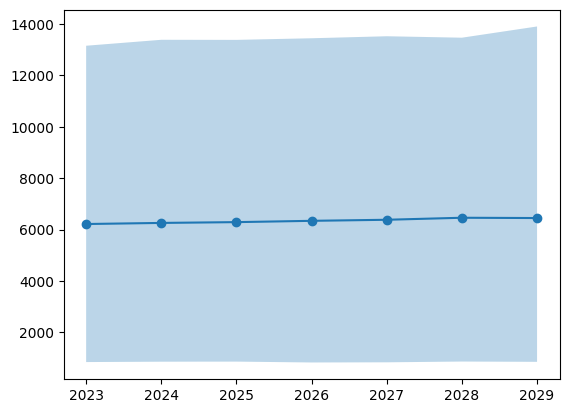

In [11]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [12]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year    mean  2.5%   97.5%
0  25_to_29  female  2023  4.5250   0.0  21.100
1  25_to_29  female  2024  4.4500   0.0  17.050
2  25_to_29  female  2025  4.2625   0.0  17.000
3  25_to_29  female  2026  4.5000   0.0  18.075
4  25_to_29  female  2027  3.9875   0.0  18.025

In [14]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model12vv_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [13]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

age     sex  year  input_draw       ptvalue
0  25_to_29  female  2023          29  27022.280630
1  25_to_29  female  2023         232  27028.643395
2  25_to_29  female  2023         357  26876.473648
3  25_to_29  female  2023         394  26896.711841
4  25_to_29  female  2023         602  26471.249829

In [14]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.001350  0.000668  0.002453
1  25_to_29  female  2024  0.001344  0.000661  0.002776
2  25_to_29  female  2025  0.001298  0.000709  0.002345
3  25_to_29  female  2026  0.001381  0.000682  0.002806
4  25_to_29  female  2027  0.001228  0.000833  0.002305

In [17]:
%%capture 
with PdfPages('model12_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [18]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model12_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [15]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

index       age     sex  year                  cause  mean  2.5%  97.5%
0      0  25_to_29  female  2023  acute_ischemic_stroke   0.1   0.0  0.775
1      8  25_to_29  female  2024  acute_ischemic_stroke   0.4   0.0  3.100
2     16  25_to_29  female  2025  acute_ischemic_stroke   0.2   0.0  1.000
3     24  25_to_29  female  2026  acute_ischemic_stroke   0.1   0.0  0.775
4     32  25_to_29  female  2027  acute_ischemic_stroke   0.1   0.0  0.775

In [16]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

index       age     sex  year  input_draw                  cause  value
0      0  25_to_29  female  2023          29  acute_ischemic_stroke      1
1      8  25_to_29  female  2023         232  acute_ischemic_stroke      0
2     16  25_to_29  female  2023         357  acute_ischemic_stroke      0
3     24  25_to_29  female  2023         394  acute_ischemic_stroke      0
4     32  25_to_29  female  2023         602  acute_ischemic_stroke      0

In [17]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000004   0.0  0.000029
1  25_to_29  female  2024  0.000015   0.0  0.000116
2  25_to_29  female  2025  0.000008   0.0  0.000039
3  25_to_29  female  2026  0.000004   0.0  0.000030
4  25_to_29  female  2027  0.000004   0.0  0.000030

In [22]:
%%capture 
with PdfPages('model12_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [18]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

age     sex  year      mean      2.5%     97.5%
0    25_to_29  female  2023  0.000004  0.000000  0.000029
1    25_to_29  female  2024  0.000000  0.000000  0.000000
2    25_to_29  female  2025  0.000000  0.000000  0.000000
3    25_to_29  female  2026  0.000000  0.000000  0.000000
..        ...     ...   ...       ...       ...       ...
206   95_plus    male  2026  0.009632  0.003833  0.018168
207   95_plus    male  2027  0.008824  0.004837  0.012922
208   95_plus    male  2028  0.012513  0.006812  0.017639
209   95_plus    male  2029  0.007054  0.002100  0.013630

[210 rows x 6 columns]

In [24]:
%%capture
with PdfPages('model12_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [19]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [20]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000174   0.0  0.000907
1  25_to_29  female  2024  0.000185   0.0  0.001085
2  25_to_29  female  2025  0.000145   0.0  0.000825
3  25_to_29  female  2026  0.000158   0.0  0.000976
4  25_to_29  female  2027  0.000133   0.0  0.000722

In [27]:
%%capture
with PdfPages('model12_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [28]:
%%capture
with PdfPages('model12_acute_MI_csmr_byyear.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for age in acute_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [21]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.000153  0.000037  0.000426
1  25_to_29  female  2024  0.000152  0.000037  0.000552
2  25_to_29  female  2025  0.000179  0.000000  0.000596
3  25_to_29  female  2026  0.000154  0.000000  0.000555
4  25_to_29  female  2027  0.000185  0.000000  0.000653

In [30]:
%%capture
with PdfPages('model12_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [31]:
%%capture
with PdfPages('model12_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [32]:
## Older age groups having an increased CSMR over time. This is probably related to the other issue we 
## have seen with post MI. 

#### Heart Failure

In [22]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000209   0.0  0.000603
1  25_to_29  female  2024  0.000207   0.0  0.000547
2  25_to_29  female  2025  0.000220   0.0  0.000554
3  25_to_29  female  2026  0.000222   0.0  0.000569
4  25_to_29  female  2027  0.000157   0.0  0.000440

In [34]:
%%capture
with PdfPages('model12_HF_csmr.pdf') as pdf:
    for sex in HF_rate_summ.sex.unique():
        for year in HF_rate_summ.year.unique():
            plt.figure() 
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [23]:
state_person_time['state'].unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_heart_failure_residual',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure',
       'ischemic_stroke_acute_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke'], dtype=object)

In [24]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.060526  0.019140  0.160457
1  25_to_29  female  2024  0.049413  0.014749  0.084162
2  25_to_29  female  2025  0.032626  0.000000  0.065625
3  25_to_29  female  2026  0.039078  0.000000  0.090478
4  25_to_29  female  2027  0.044453  0.000000  0.084736

In [37]:
%%capture
with PdfPages('model12_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Heart Failure EMR

In [25]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

age     sex  year      mean  2.5%      97.5%
0  25_to_29  female  2023  0.684491   0.0   3.843853
1  25_to_29  female  2024  0.770356   0.0   4.913322
2  25_to_29  female  2025  3.996524   0.0  15.653571
3  25_to_29  female  2026       inf   0.0        inf
4  25_to_29  female  2027       inf   0.0        inf

In [39]:
%%capture
with PdfPages('model12_HF_emr.pdf') as pdf:
    for sex in HF_emr_summ.sex.unique():
        for year in HF_emr_summ.year.unique():
            plt.figure() 
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [40]:
## Looks a little wonky but steady over time 

### Prevalence 

#### Chronic + Acute Stroke

In [26]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000031   0.0  0.000180
1  25_to_29  female  2024  0.000029   0.0  0.000168
2  25_to_29  female  2025  0.000028   0.0  0.000157
3  25_to_29  female  2026  0.000029   0.0  0.000180
4  25_to_29  female  2027  0.000041   0.0  0.000241

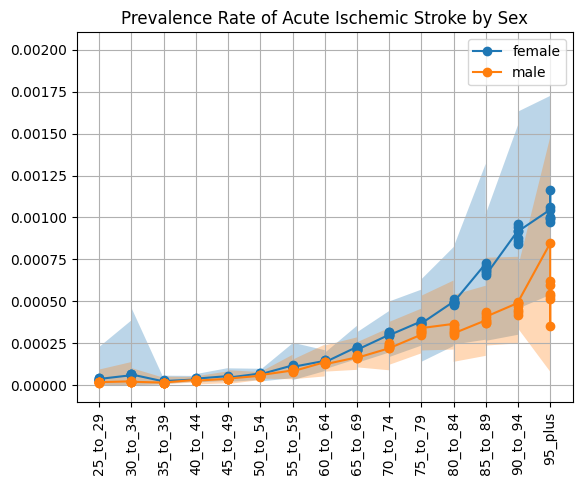

In [27]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [28]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

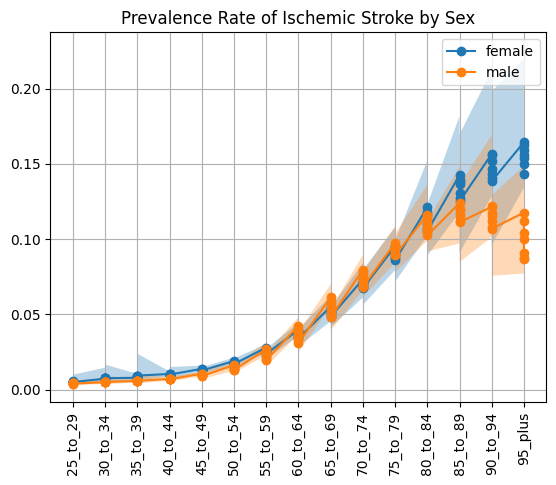

In [29]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [30]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

age     sex  year      mean          2.5%     97.5%
0  25_to_29  female  2023  0.000121  1.914915e-06  0.000389
1  25_to_29  female  2024  0.000111  6.464886e-07  0.000332
2  25_to_29  female  2025  0.000108  1.311002e-06  0.000323
3  25_to_29  female  2026  0.000104  6.626671e-07  0.000333
4  25_to_29  female  2027  0.000090  0.000000e+00  0.000244

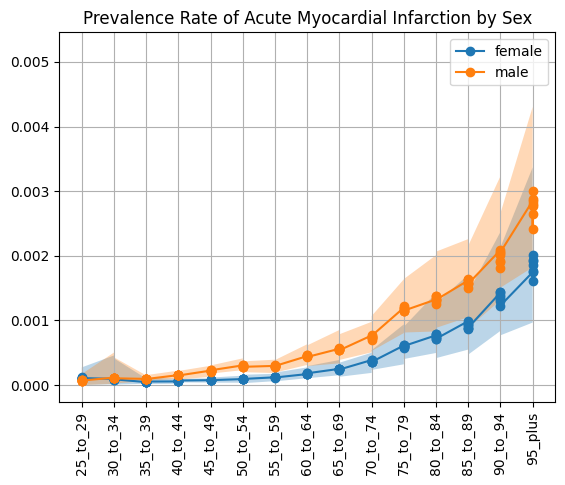

In [31]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [32]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.002909  0.000986  0.007277
1  25_to_29  female  2024  0.003294  0.000757  0.009114
2  25_to_29  female  2025  0.003608  0.000477  0.010417
3  25_to_29  female  2026  0.003697  0.000361  0.010982
4  25_to_29  female  2027  0.003820  0.000296  0.011305

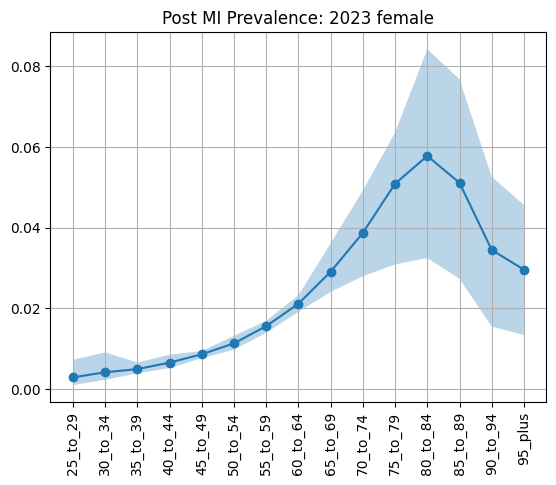

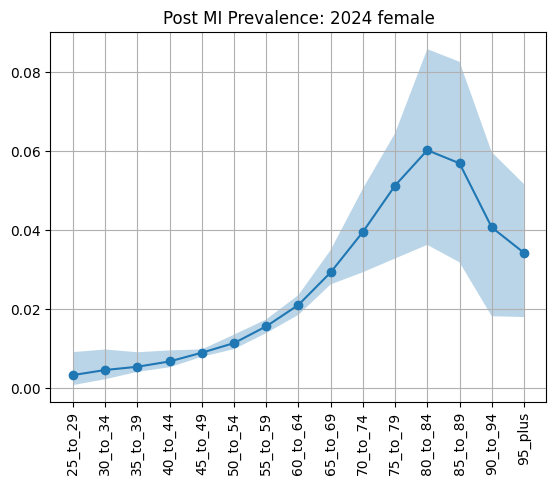

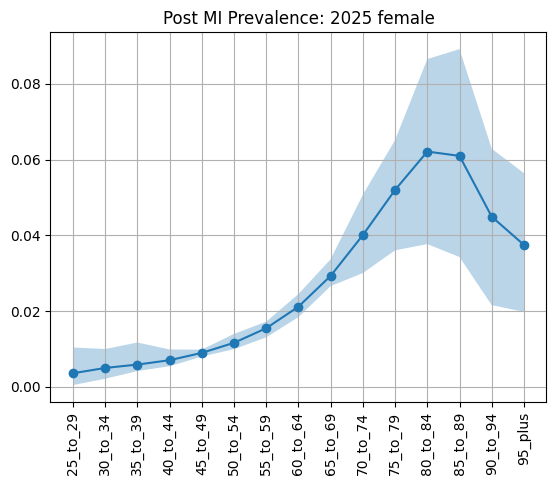

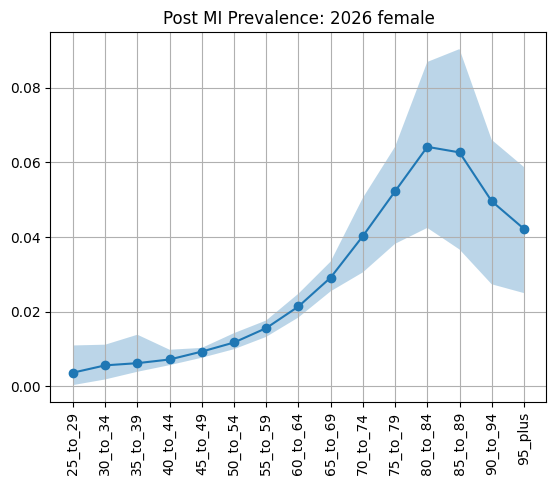

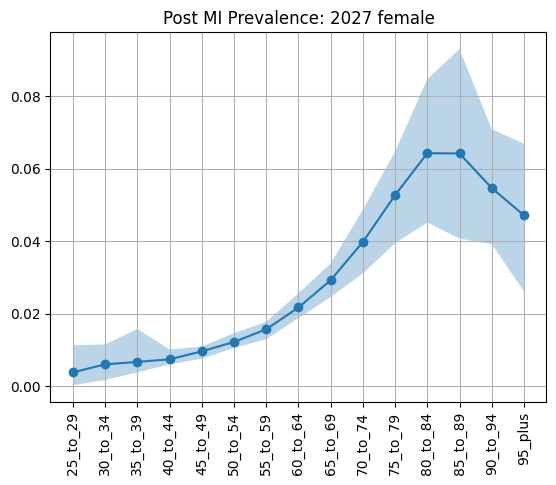

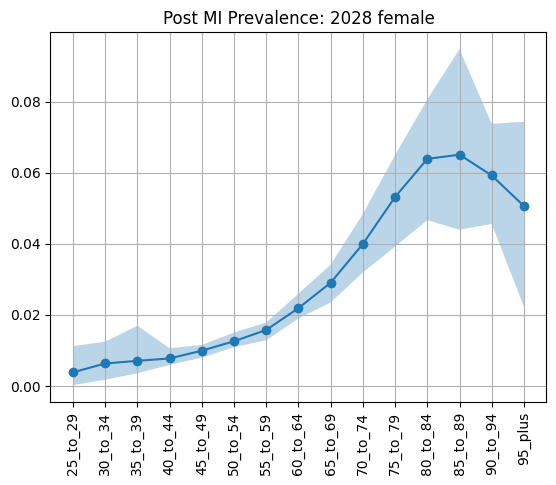

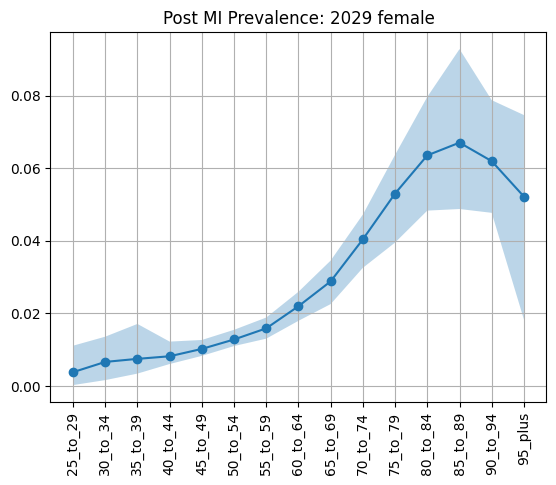

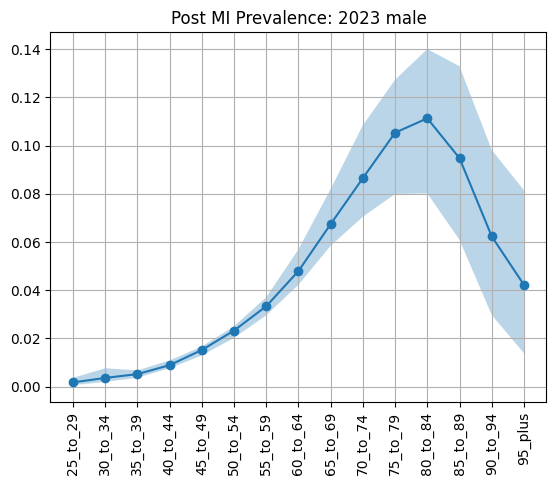

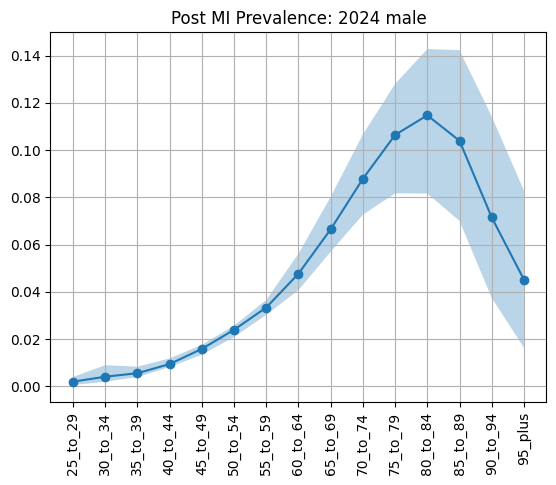

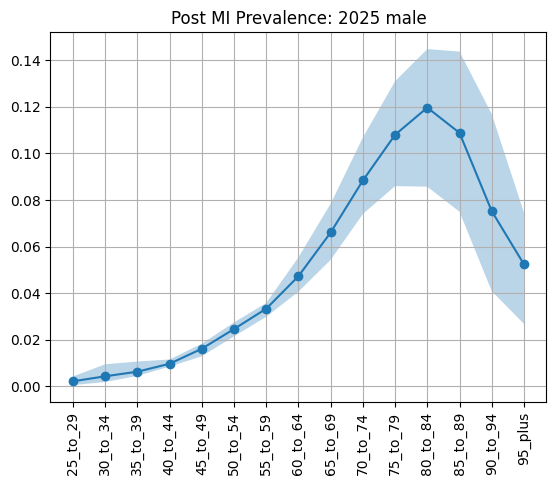

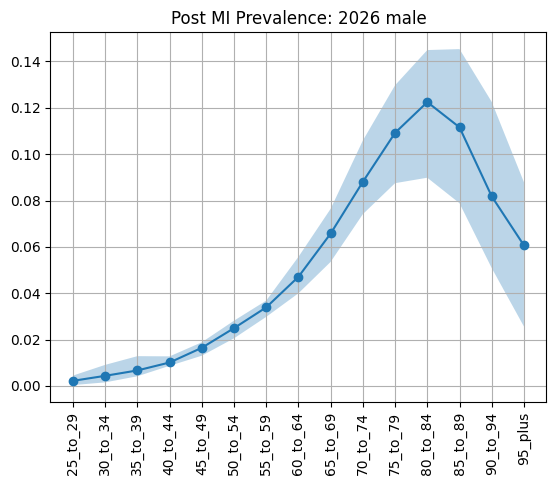

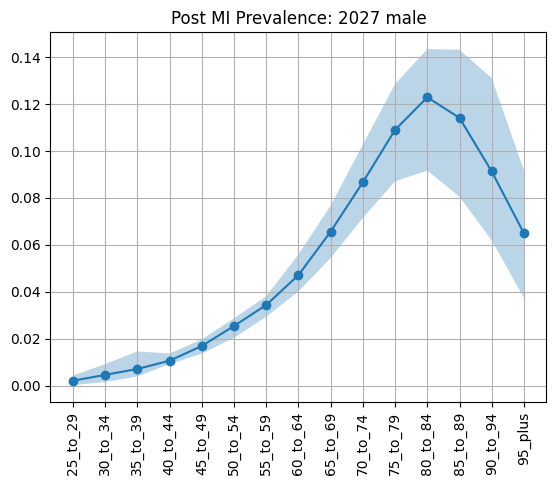

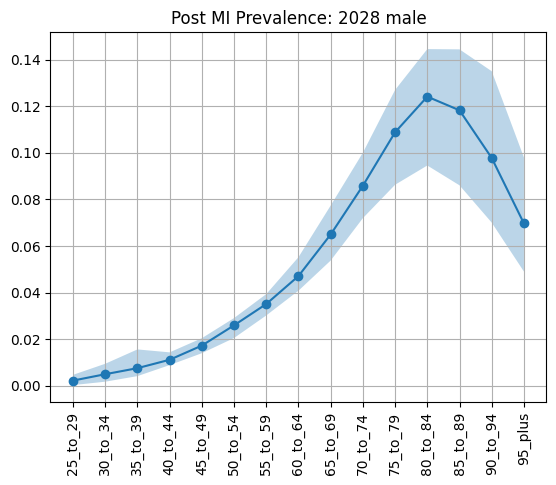

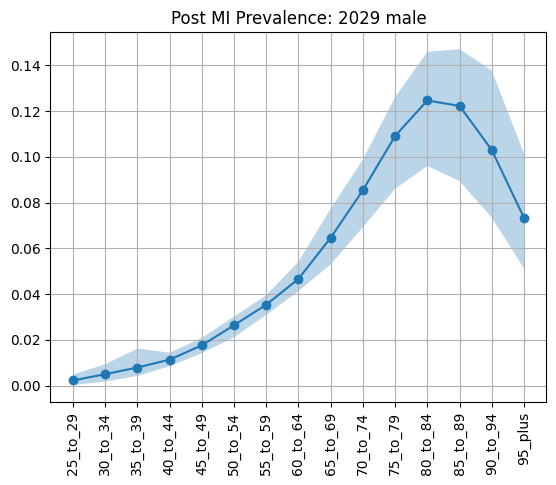

In [33]:
#%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [49]:
##You see the same kinda weird thing going on with the later years/older age groups as noted above

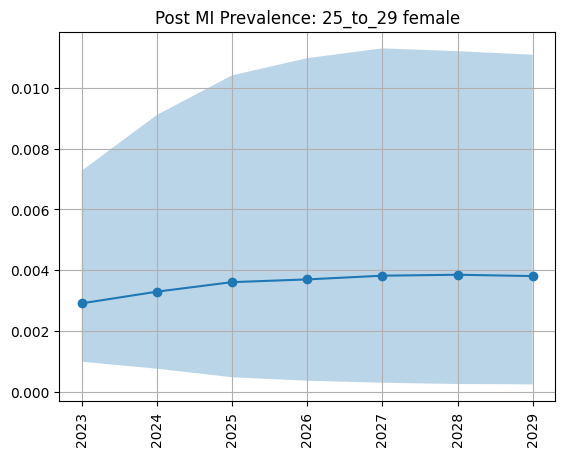

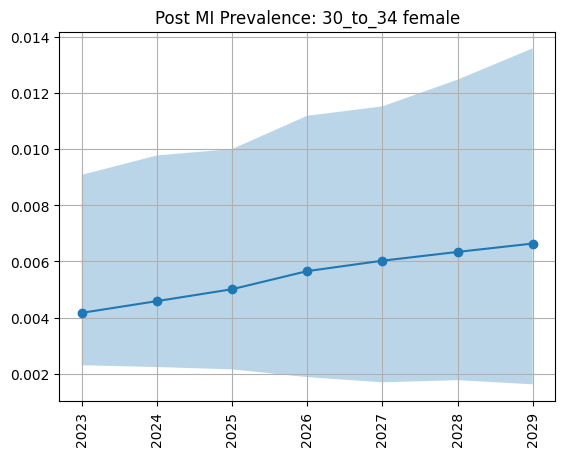

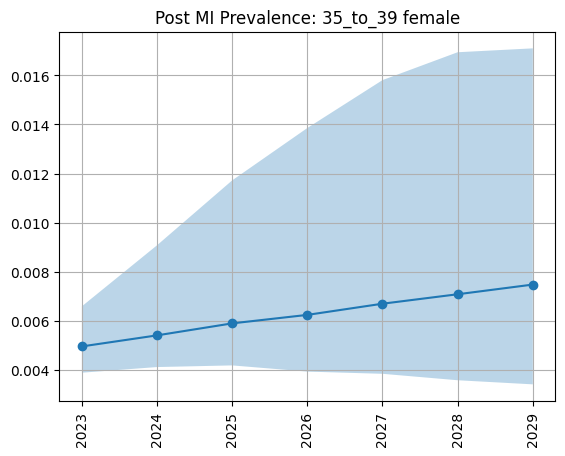

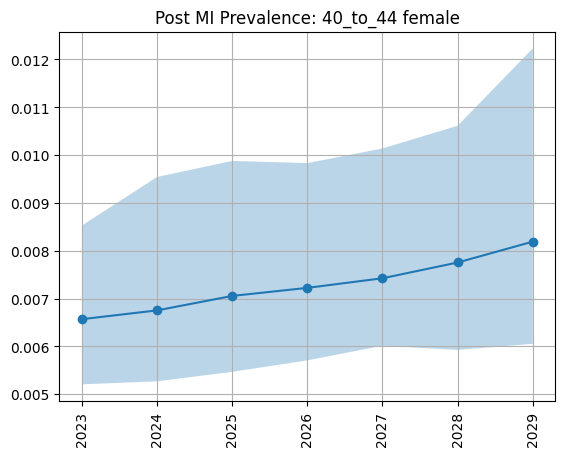

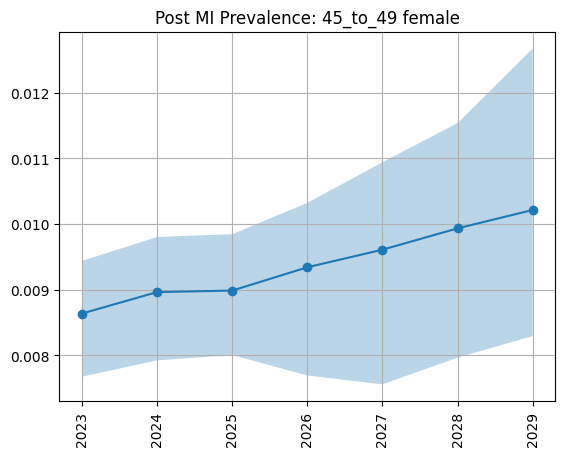

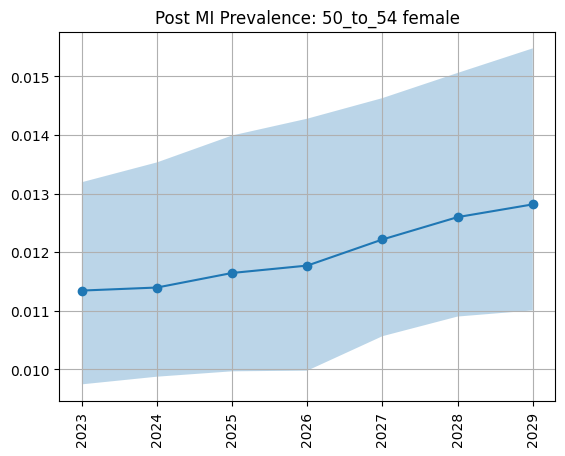

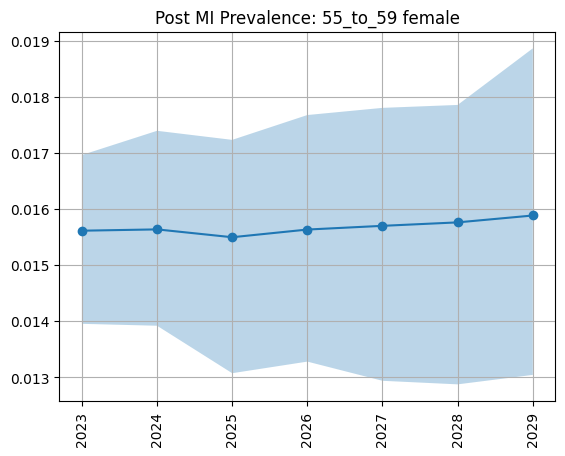

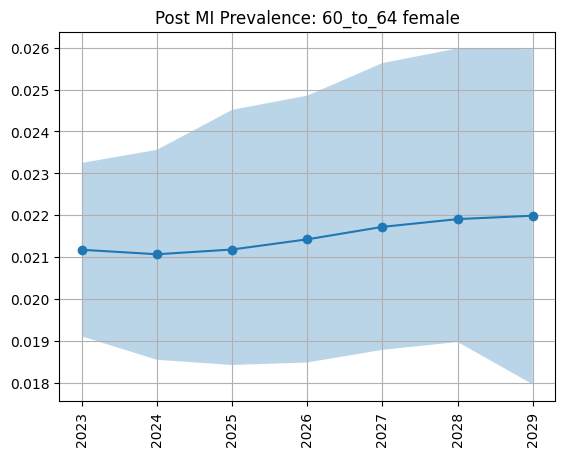

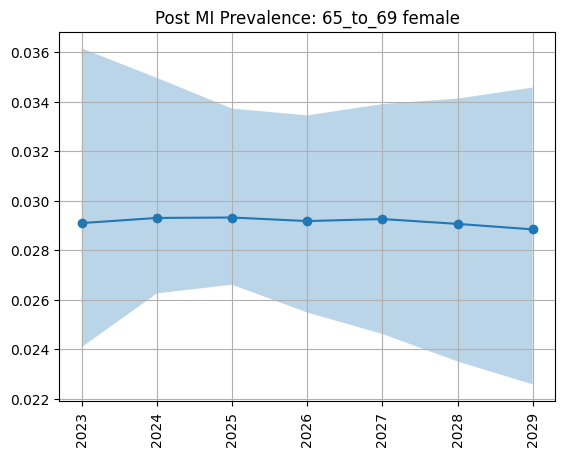

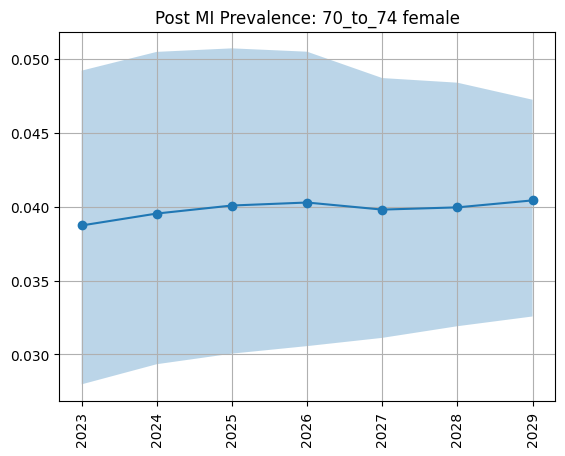

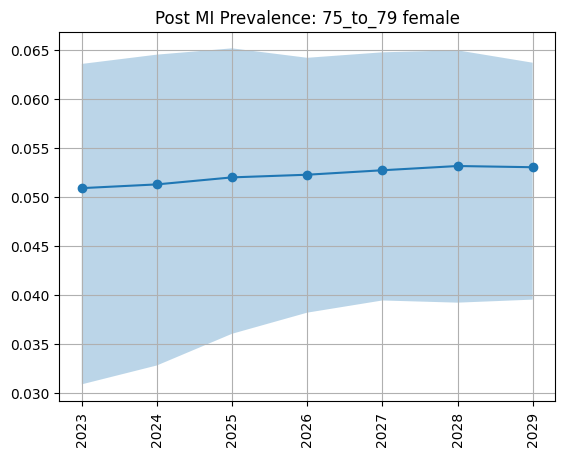

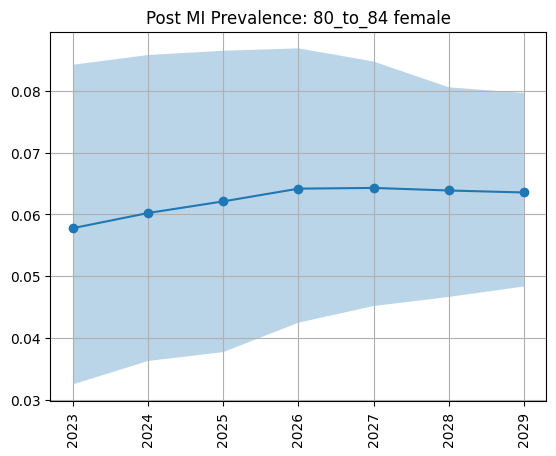

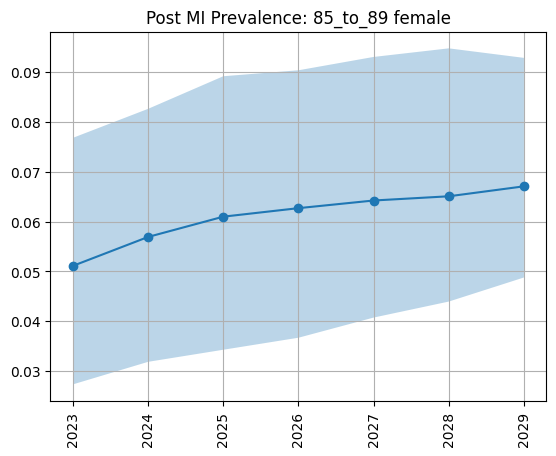

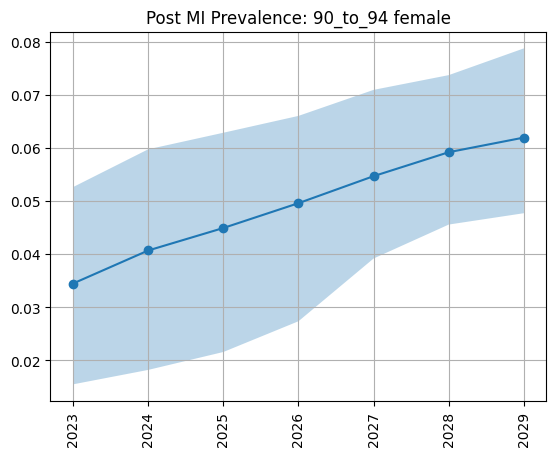

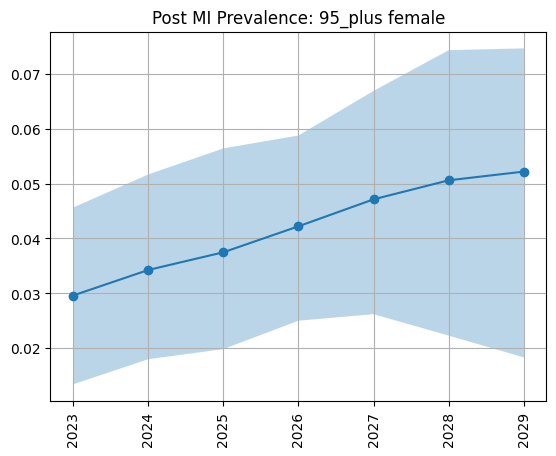

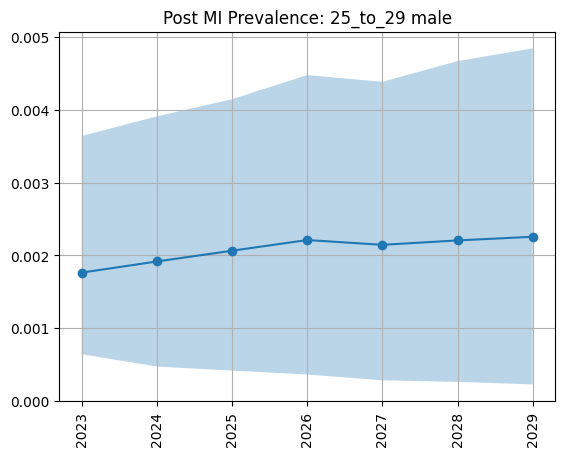

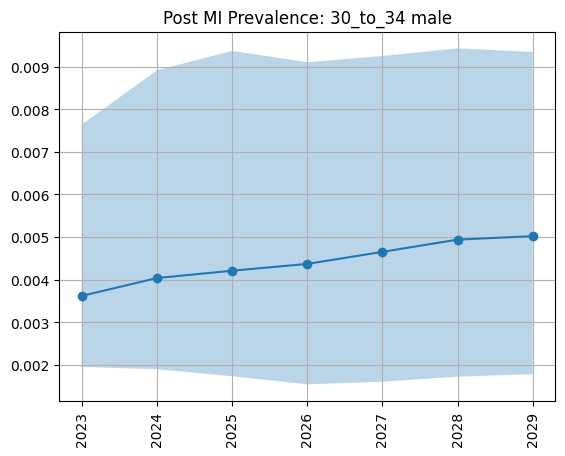

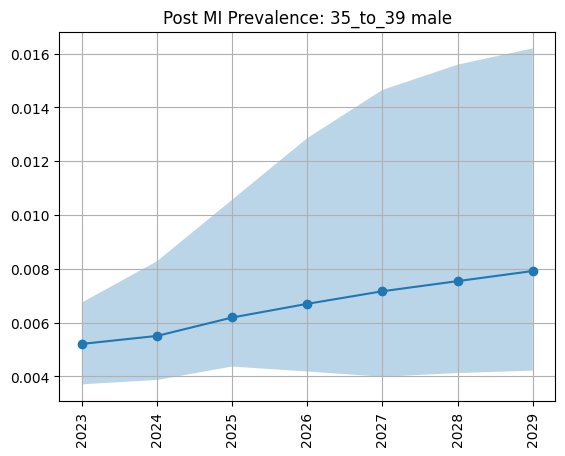

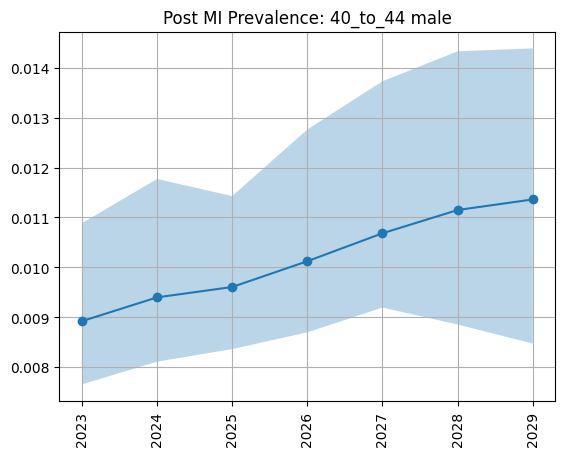

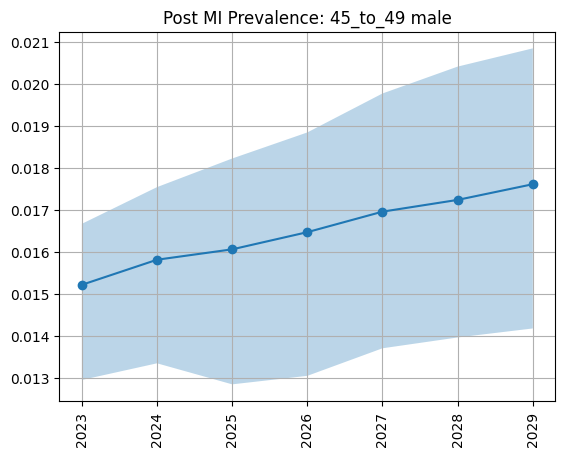

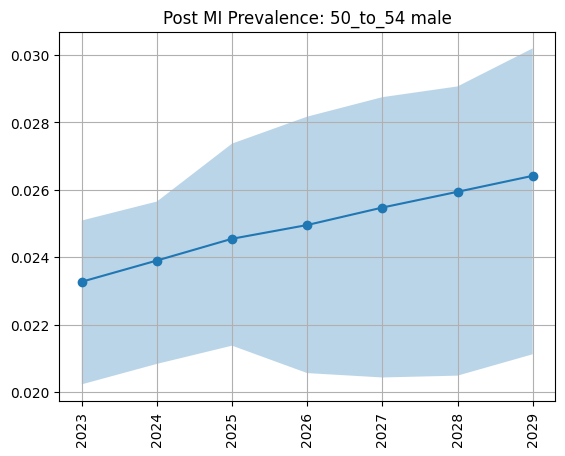

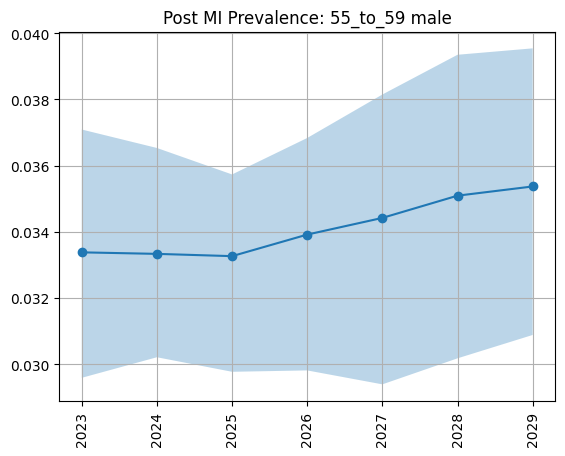

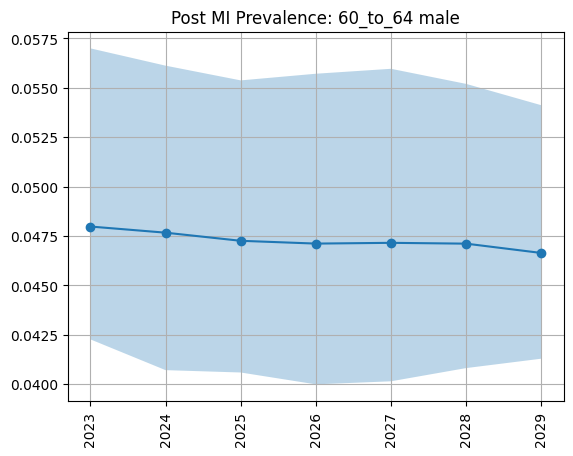

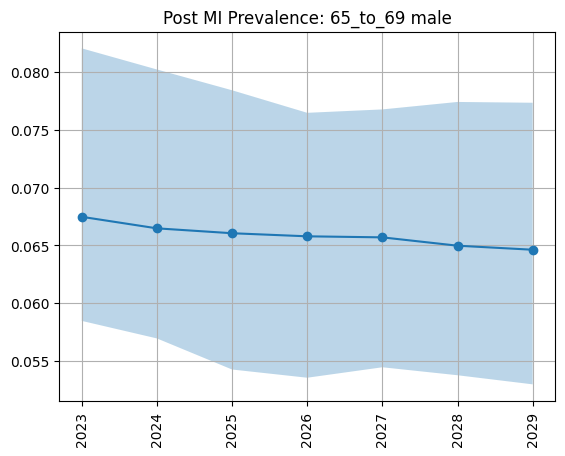

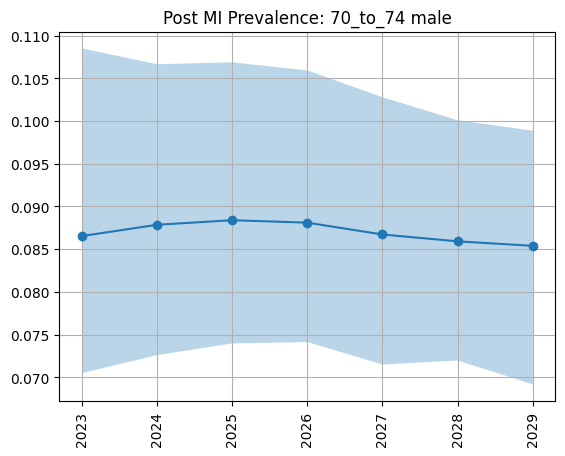

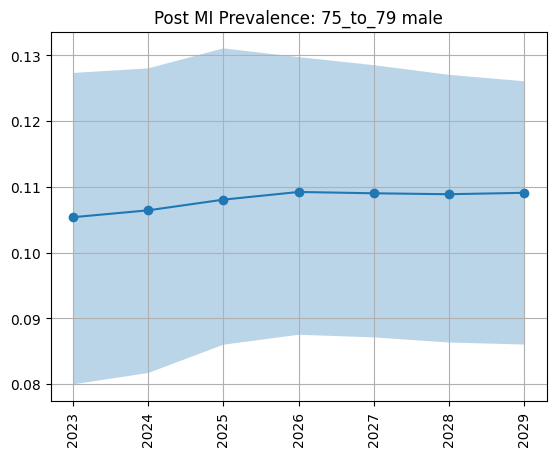

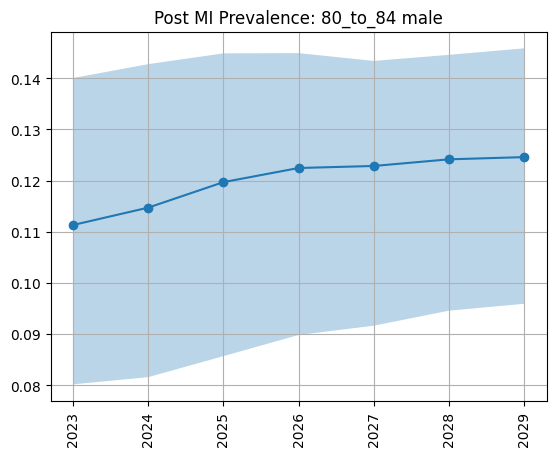

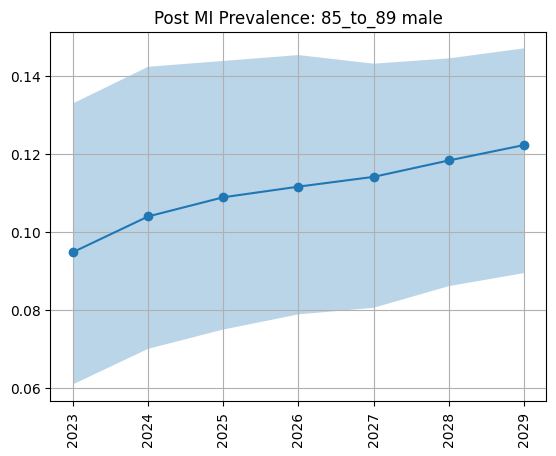

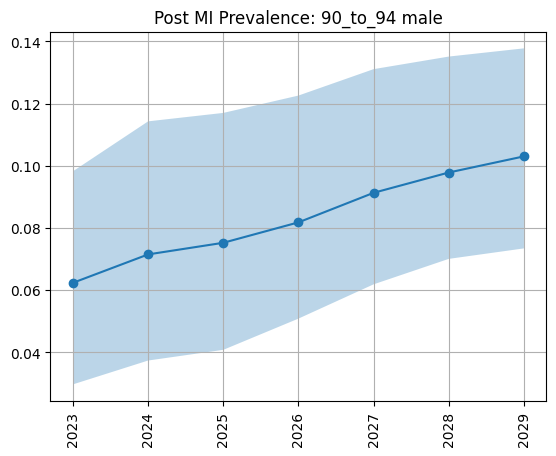

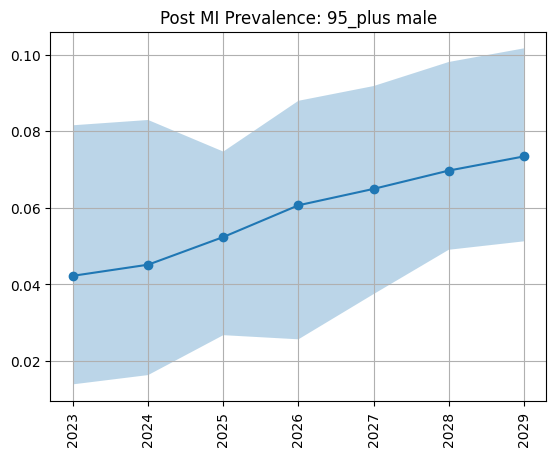

In [34]:
#%%capture
for sex in prev_post_MI_summ.sex.unique():
    for age in prev_post_MI_summ.age.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [51]:
##This seems to trend upwards. I am a bit concerned about it

##Still true, even more true now. This is a concern

In [52]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [35]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   0.0   0.0    0.0
                2024   0.0   0.0    0.0
                2025   0.0   0.0    0.0
                2026   0.0   0.0    0.0
                2027   0.0   0.0    0.0

In [54]:
%%capture
for sex in tran_rate_post_to_hf_summ.index.get_level_values('sex').unique():
    for age in tran_rate_post_to_hf_summ.index.get_level_values('age').unique():
        plt.figure() 
        subdata = tran_rate_post_to_hf_summ.loc[(tran_rate_post_to_hf_summ.index.get_level_values('sex')==sex) & (tran_rate_post_to_hf_summ.index.get_level_values('age')==age)]
        plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('year'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI to HF Rate Incidence: {age} {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.ylim(0,0.04)

In [36]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

In [56]:
%%capture
for sex in tran_rate_ami_to_post_summ.index.get_level_values('sex').unique():
    for age in tran_rate_ami_to_post_summ.index.get_level_values('age').unique():
        plt.figure() 
        subdata = tran_rate_ami_to_post_summ.loc[(tran_rate_ami_to_post_summ.index.get_level_values('sex')==sex) & (tran_rate_ami_to_post_summ.index.get_level_values('age')==age)]
        plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('year'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'AMI to Post Rate Incidence: {age} {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.ylim(0,0.04)

### Prevalence of Heart Failure

In [37]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.001251  0.000099  0.003018
1  25_to_29  female  2024  0.001270  0.000081  0.003137
2  25_to_29  female  2025  0.001250  0.000040  0.003217
3  25_to_29  female  2026  0.001254  0.000046  0.003073
4  25_to_29  female  2027  0.001283  0.000059  0.003227

In [58]:
%%capture
for sex in prev_HF_summ.sex.unique():
    for year in prev_HF_summ.year.unique():
        plt.figure() 
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [59]:
%%capture
for sex in prev_HF_summ.sex.unique():
    for age in prev_HF_summ.age.unique():
        plt.figure() 
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [60]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [38]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

index       age     sex  year  \
0     10  25_to_29  female  2023   
1     21  25_to_29  female  2024   
2     32  25_to_29  female  2025   
3     43  25_to_29  female  2026   
4     54  25_to_29  female  2027   

                                          transition  mean  2.5%   97.5%  
0  ischemic_stroke_susceptible_to_ischemic_stroke...   8.1   0.0  40.250  
1  ischemic_stroke_susceptible_to_ischemic_stroke...   7.4   0.0  40.775  
2  ischemic_stroke_susceptible_to_ischemic_stroke...   7.6   0.0  36.025  
3  ischemic_stroke_susceptible_to_ischemic_stroke...   7.0   0.0  37.675  
4  ischemic_stroke_susceptible_to_ischemic_stroke...   9.0   0.0  47.425

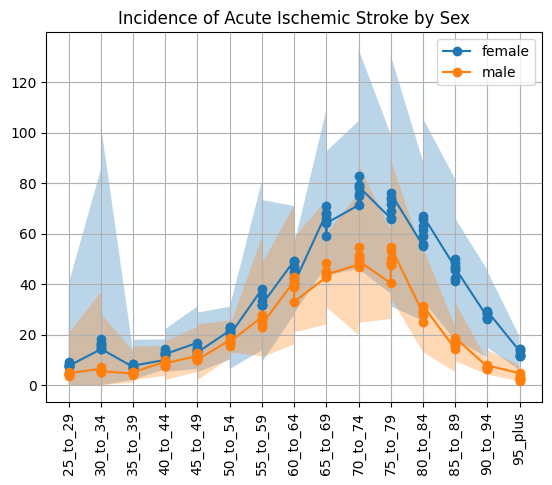

In [39]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [40]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

index       age     sex  year  \
0     80  25_to_29  female  2023   
1     81  25_to_29  female  2023   
2     82  25_to_29  female  2023   
3     83  25_to_29  female  2023   
4     84  25_to_29  female  2023   

                                            state  input_draw       ptvalue  
0  ischemic_stroke_susceptible_to_ischemic_stroke          29  26786.551677  
1  ischemic_stroke_susceptible_to_ischemic_stroke         232  26902.614648  
2  ischemic_stroke_susceptible_to_ischemic_stroke         357  26734.269678  
3  ischemic_stroke_susceptible_to_ischemic_stroke         394  26777.045859  
4  ischemic_stroke_susceptible_to_ischemic_stroke         602  26303.518138

In [41]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

age     sex  year      mean  2.5%     97.5%
0  25_to_29  female  2023  0.000301   0.0  0.001492
1  25_to_29  female  2024  0.000278   0.0  0.001528
2  25_to_29  female  2025  0.000290   0.0  0.001371
3  25_to_29  female  2026  0.000269   0.0  0.001449
4  25_to_29  female  2027  0.000349   0.0  0.001841

In [65]:
%%capture
with PdfPages('model12_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [42]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [43]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.001583  0.000033  0.005323
                2024  0.001435  0.000008  0.003989
                2025  0.001405  0.000009  0.004242
                2026  0.001358  0.000009  0.004213
                2027  0.001203  0.000000  0.003331

In [68]:
%%capture
with PdfPages('model12_acute_MI_inc.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Incidence of Heart Failure 

In [44]:
tran['transition'].unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [45]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000717  0.000519  0.000898
                2024  0.000703  0.000297  0.001004
                2025  0.000723  0.000465  0.001110
                2026  0.000669  0.000278  0.000977
                2027  0.000677  0.000354  0.001085

In [71]:
%%capture
with PdfPages('model12_HF_inc.pdf') as pdf:
    for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
        for year in tran_rate_HF_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Ratio in Prevalence of HF IHD to HF Resid 

In [46]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['IHD_rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_resid['resid_rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_ratio = prev_HF_IHD.merge(prev_HF_resid[['age','sex','year','input_draw','resid_rate']], on=['age','sex','year','input_draw'])
prev_HF_ratio['IHD_ratio'] = prev_HF_ratio['IHD_rate']/ (prev_HF_ratio['IHD_rate'] + prev_HF_ratio['resid_rate'])
prev_HF_ratio_summ = (prev_HF_ratio
                 .groupby(['age', 'sex', 'year'])
                 .IHD_ratio.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_ratio_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.079788  0.042678  0.110113
1  25_to_29  female  2024  0.068597  0.029556  0.123654
2  25_to_29  female  2025  0.061445  0.010555  0.108235
3  25_to_29  female  2026  0.065630  0.011711  0.107163
4  25_to_29  female  2027  0.062334  0.011510  0.096557

In [73]:
%%capture
for sex in prev_HF_ratio_summ.sex.unique():
    for age in prev_HF_ratio_summ.age.unique():
        plt.figure() 
        subdata = prev_HF_ratio_summ.loc[(prev_HF_ratio_summ.sex==sex) & (prev_HF_ratio_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Ratio the is IHD Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [74]:
%%capture
for sex in prev_HF_ratio_summ.sex.unique():
    for year in prev_HF_ratio_summ.year.unique():
        plt.figure() 
        subdata = prev_HF_ratio_summ.loc[(prev_HF_ratio_summ.sex==sex) & (prev_HF_ratio_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Ratio that is IHD Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

### Artifacts

In [47]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/

alabama-BAD-PAFS.hdf  alabama.hdf  washington.hdf


In [48]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [49]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

location     sex  age_start  age_end  year_start  year_end          value
0  Alabama  Female       25.0     30.0        2019      2020  171101.787730
1  Alabama  Female       30.0     35.0        2019      2020  162707.127245
2  Alabama  Female       35.0     40.0        2019      2020  160738.561697
3  Alabama  Female       40.0     45.0        2019      2020  151811.937430
4  Alabama  Female       45.0     50.0        2019      2020  160780.871213

In [50]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'healthcare_entity.outpatient_visits.outpatient_envelope',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction_and_heart_failure.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.heart_failure_from_ischemic_heart_disease.prevalence',
 '

In [51]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

sex  age_start  age_end  year_start  year_end   draw_0   draw_1  \
0  Female       25.0     30.0        2019      2020  0.31588  0.40003   
1  Female       30.0     35.0        2019      2020  0.30193  0.33175   
2  Female       35.0     40.0        2019      2020  0.28018  0.29485   
3  Female       40.0     45.0        2019      2020  0.24315  0.27495   
4  Female       45.0     50.0        2019      2020  0.19085  0.27205   

    draw_2   draw_3   draw_4  ...  draw_990  draw_991  draw_992  draw_993  \
0  0.32045  0.38893  0.24140  ...   0.27915   0.29902   0.33340   0.28170   
1  0.28828  0.37140  0.24475  ...   0.27680   0.29742   0.35445   0.23455   
2  0.27522  0.29580  0.32445  ...   0.29240   0.29728   0.32355   0.24025   
3  0.29525  0.26428  0.35000  ...   0.28105   0.31522   0.29495   0.24098   
4  0.34835  0.27682  0.32140  ...   0.24275   0.35128   0.26865   0.23673   

   draw_994  draw_995  draw_996  draw_997  draw_998  draw_999  
0   0.45043   0.26388   0.31837   0.28815   0.23798   0.20685  
1   0.42553   0.22783   0.26775   0.28548   0.25033   0.25325  
2   0.35158   0.27568   0.30525   0.40163   0.30818   0.44195  
3   0.31315   0.28515   0.32320   0.41060   0.31078   0.45695  
4   0.31025   0.25625   0.32160   0.31240   0.25812   0.29825  

[5 rows x 1005 columns]

In [52]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [53]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000948  0.000813   
1  female       30.0     35.0        2019      2020  0.001361  0.001177   
2  female       35.0     40.0        2019      2020  0.001694  0.001470   
3  female       40.0     45.0        2019      2020  0.002589  0.002260   
4  female       45.0     50.0        2019      2020  0.003657  0.003190   

      97.5% location                        measure age_group  
0  0.001116  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.001591  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.001975  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.003007  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.004251  Alabama  cause_specific_mortality_rate  45_to_49

In [54]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.001313  0.000626  0.002685
1  25_to_29    male  0.002403  0.001582  0.003336
2  30_to_34  female  0.001533  0.000939  0.002917
3  30_to_34    male  0.002610  0.001732  0.004328
4  35_to_39  female  0.001773  0.001222  0.002383

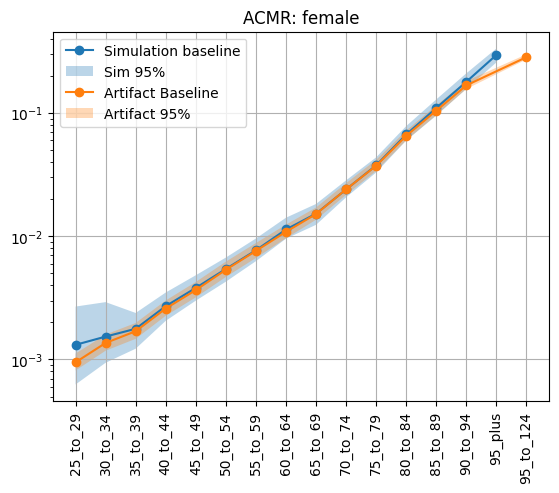

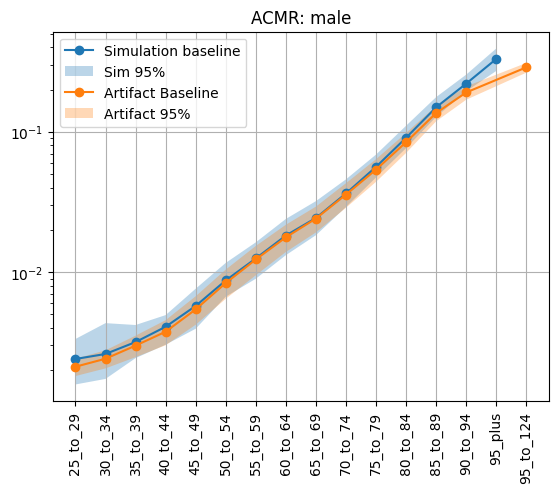

In [55]:
with PdfPages('model12_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [56]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000002  0.000002   
1  female       30.0     35.0        2019      2020  0.000004  0.000002   
2  female       35.0     40.0        2019      2020  0.000006  0.000004   
3  female       40.0     45.0        2019      2020  0.000011  0.000006   
4  female       45.0     50.0        2019      2020  0.000016  0.000013   

      97.5% location                        measure age_group  
0  0.000003  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.000006  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.000008  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.000015  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.000020  Alabama  cause_specific_mortality_rate  45_to_49

In [57]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [58]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [59]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [60]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.000009   0.0  0.000077
1  25_to_29    male  0.000010   0.0  0.000097
2  30_to_34  female  0.000017   0.0  0.000198
3  30_to_34    male  0.000010   0.0  0.000076
4  35_to_39  female  0.000008   0.0  0.000039

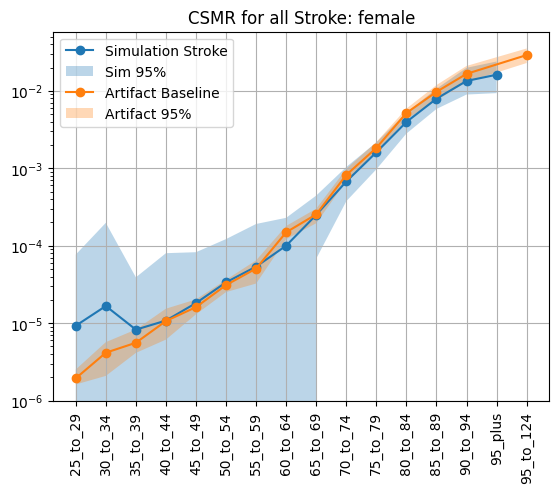

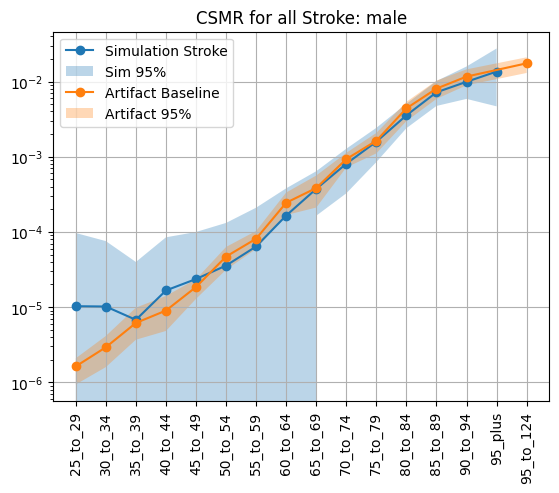

In [61]:
with PdfPages('model12_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [62]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000544  0.000431   
1  female       30.0     35.0        2019      2020  0.000654  0.000513   
2  female       35.0     40.0        2019      2020  0.000780  0.000602   
3  female       40.0     45.0        2019      2020  0.000847  0.000734   
4  female       45.0     50.0        2019      2020  0.001435  0.001256   

      97.5% location                        measure age_group  
0  0.000627  Alabama  cause_specific_mortality_rate  25_to_29  
1  0.000744  Alabama  cause_specific_mortality_rate  30_to_34  
2  0.001071  Alabama  cause_specific_mortality_rate  35_to_39  
3  0.001010  Alabama  cause_specific_mortality_rate  40_to_44  
4  0.001501  Alabama  cause_specific_mortality_rate  45_to_49

In [63]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [64]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

age     sex      mean      2.5%     97.5%
0   25_to_29  female  0.000894  0.000303  0.002247
1   25_to_29    male  0.001046  0.000416  0.001845
2   30_to_34  female  0.000804  0.000375  0.002074
3   30_to_34    male  0.001143  0.000601  0.002729
..       ...     ...       ...       ...       ...
26  90_to_94  female  0.110034  0.084067  0.142634
27  90_to_94    male  0.173220  0.139837  0.228025
28   95_plus  female  0.153053  0.115973  0.201648
29   95_plus    male  0.237373  0.168684  0.316485

[30 rows x 5 columns]

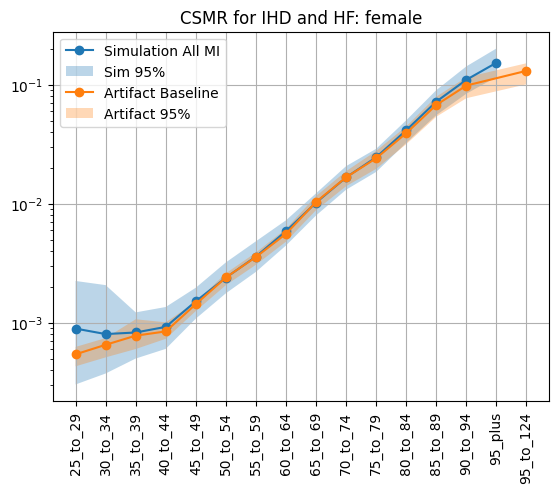

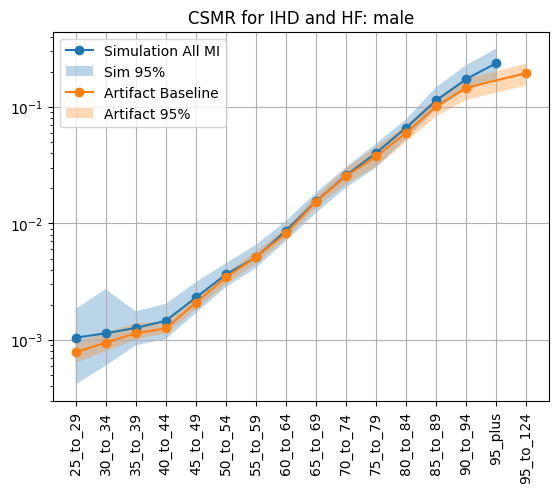

In [65]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [66]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000110  0.000045   
1  female       30.0     35.0        2019      2020  0.000164  0.000099   
2  female       35.0     40.0        2019      2020  0.000234  0.000173   
3  female       40.0     45.0        2019      2020  0.000357  0.000316   
4  female       45.0     50.0        2019      2020  0.000533  0.000380   

      97.5% location         measure age_group  
0  0.000205  Alabama  incidence_rate  25_to_29  
1  0.000253  Alabama  incidence_rate  30_to_34  
2  0.000327  Alabama  incidence_rate  35_to_39  
3  0.000463  Alabama  incidence_rate  40_to_44  
4  0.000726  Alabama  incidence_rate  45_to_49

In [67]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

age     sex  year       50%  2.5%     97.5%
0  25_to_29  female  2023  0.000112   0.0  0.001492
1  25_to_29  female  2024  0.000038   0.0  0.001528
2  25_to_29  female  2025  0.000056   0.0  0.001371
3  25_to_29  female  2026  0.000076   0.0  0.001449
4  25_to_29  female  2027  0.000096   0.0  0.001841

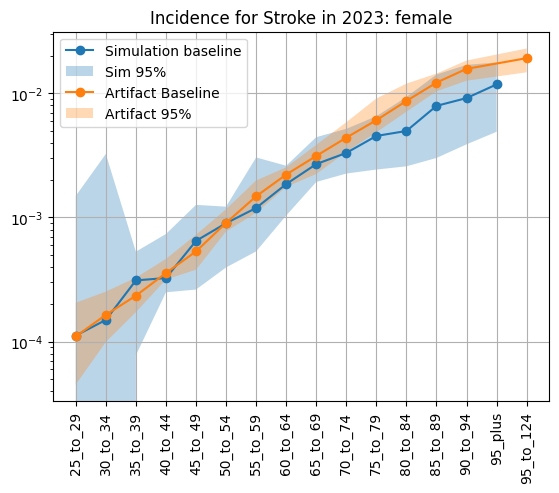

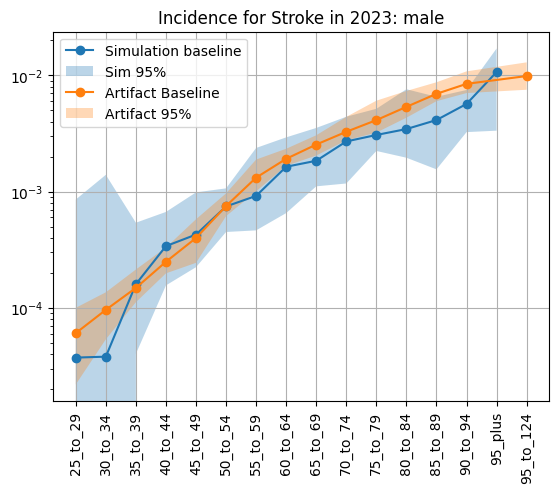

In [68]:
with PdfPages('model12_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke in 2023: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [72]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000438  0.000293   
1  female       30.0     35.0        2019      2020  0.000513  0.000354   
2  female       35.0     40.0        2019      2020  0.000468  0.000387   
3  female       40.0     45.0        2019      2020  0.000574  0.000529   
4  female       45.0     50.0        2019      2020  0.000832  0.000707   

      97.5% location         measure age_group  
0  0.000567  Alabama  incidence_rate  25_to_29  
1  0.000660  Alabama  incidence_rate  30_to_34  
2  0.000544  Alabama  incidence_rate  35_to_39  
3  0.000620  Alabama  incidence_rate  40_to_44  
4  0.000977  Alabama  incidence_rate  45_to_49

In [73]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%     97.5%
age      sex                                      
25_to_29 female  0.000000e+00  0.0   0.0  0.000000
         male    0.000000e+00  0.0   0.0  0.000000
30_to_34 female  0.000000e+00  0.0   0.0  0.000000
         male    5.430225e-07  0.0   0.0  0.000004
35_to_39 female  5.487271e-07  0.0   0.0  0.000004

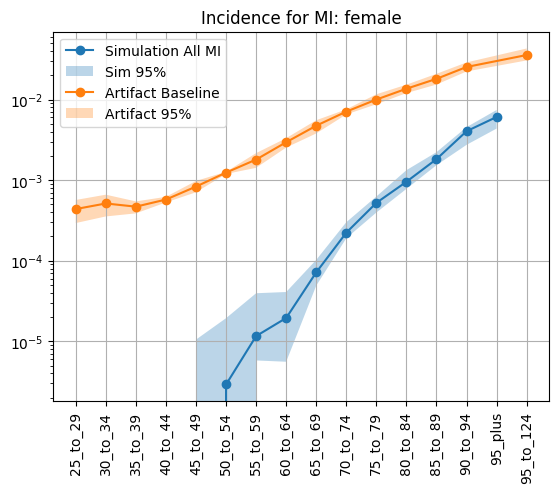

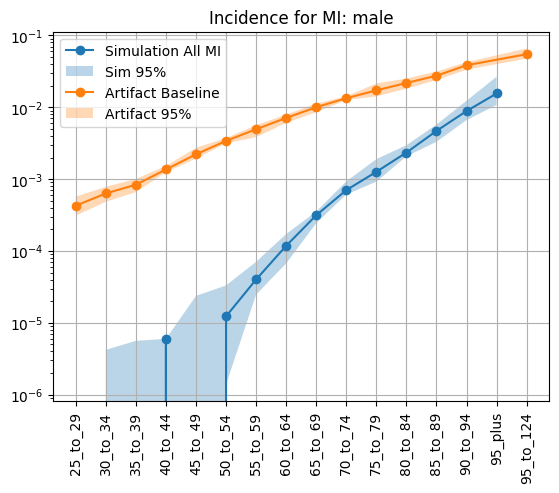

In [74]:
for sex in tran_rate_MI_HF.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_MI_HF.loc[(tran_rate_MI_HF.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [75]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 female  0.001384  0.000737  0.000019  0.003968
         male    0.000926  0.000672  0.000037  0.002285
30_to_34 female  0.001171  0.000417  0.000115  0.005289
         male    0.001452  0.000694  0.000308  0.006073
35_to_39 female  0.000674  0.000593  0.000338  0.001329

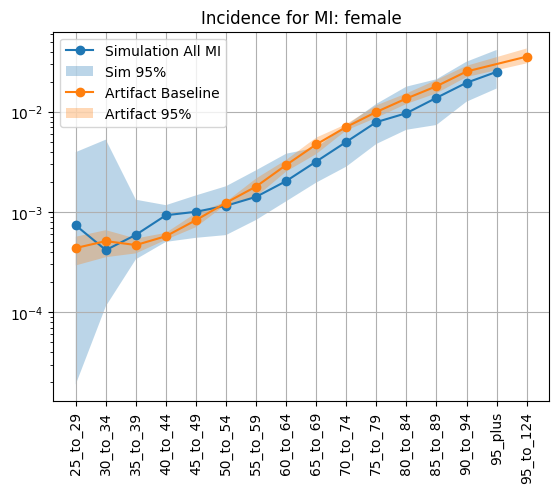

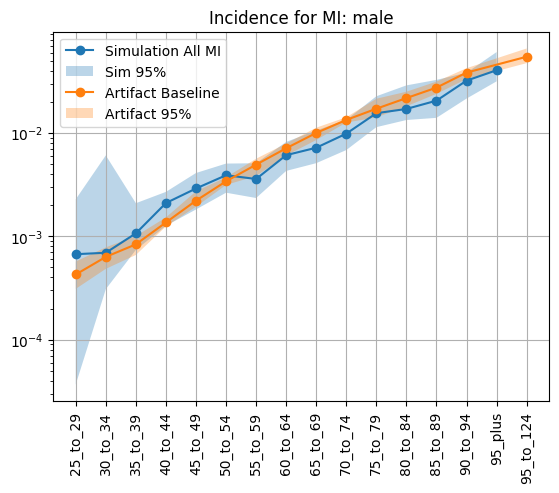

In [76]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [77]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000059  0.000040   
1  female       30.0     35.0        2019      2020  0.000085  0.000060   
2  female       35.0     40.0        2019      2020  0.000094  0.000076   
3  female       40.0     45.0        2019      2020  0.000192  0.000174   
4  female       45.0     50.0        2019      2020  0.000507  0.000459   

      97.5% location         measure age_group  
0  0.000075  Alabama  incidence_rate  25_to_29  
1  0.000105  Alabama  incidence_rate  30_to_34  
2  0.000112  Alabama  incidence_rate  35_to_39  
3  0.000209  Alabama  incidence_rate  40_to_44  
4  0.000535  Alabama  incidence_rate  45_to_49

In [78]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000064  0.000033  0.000105
         male    0.000154  0.000091  0.000219
30_to_34 female  0.000097  0.000039  0.000123
         male    0.000189  0.000130  0.000226
35_to_39 female  0.000087  0.000067  0.000120

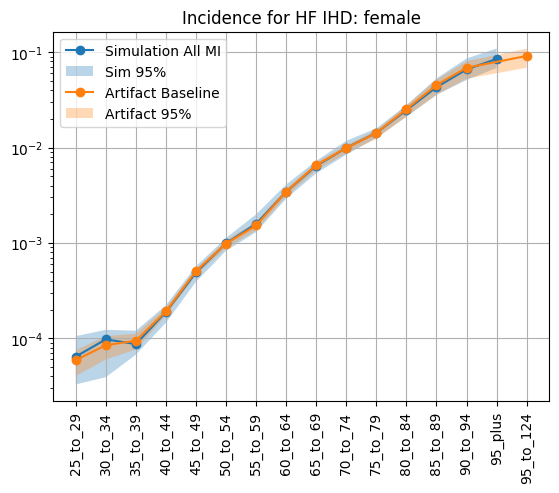

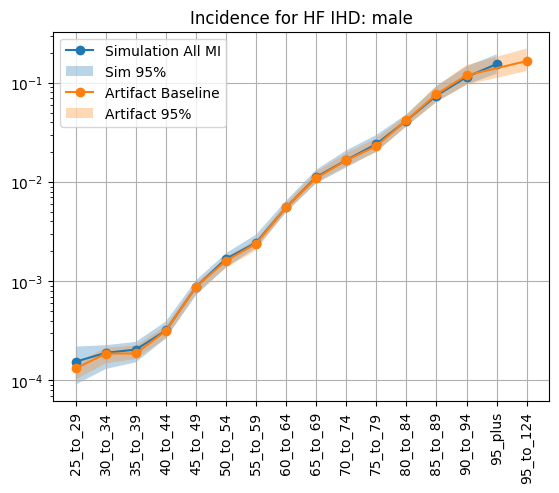

In [79]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [80]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000620  0.000422   
1  female       30.0     35.0        2019      2020  0.000593  0.000420   
2  female       35.0     40.0        2019      2020  0.000417  0.000337   
3  female       40.0     45.0        2019      2020  0.000707  0.000641   
4  female       45.0     50.0        2019      2020  0.001338  0.001214   

      97.5% location         measure age_group  
0  0.000788  Alabama  incidence_rate  25_to_29  
1  0.000739  Alabama  incidence_rate  30_to_34  
2  0.000494  Alabama  incidence_rate  35_to_39  
3  0.000772  Alabama  incidence_rate  40_to_44  
4  0.001411  Alabama  incidence_rate  45_to_49

In [81]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000626  0.000381  0.000825
         male    0.000890  0.000757  0.001035
30_to_34 female  0.000576  0.000342  0.000710
         male    0.000834  0.000660  0.000992
35_to_39 female  0.000407  0.000301  0.000485

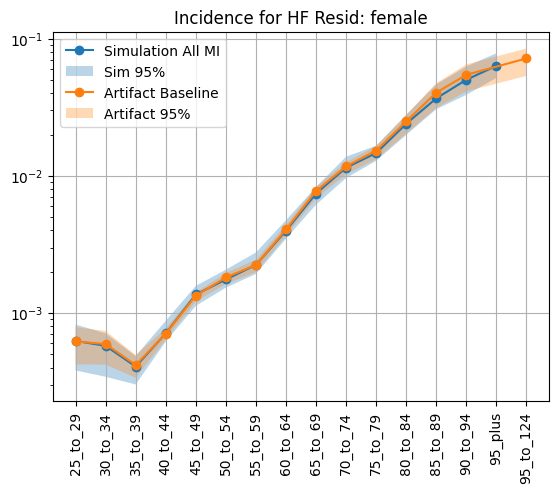

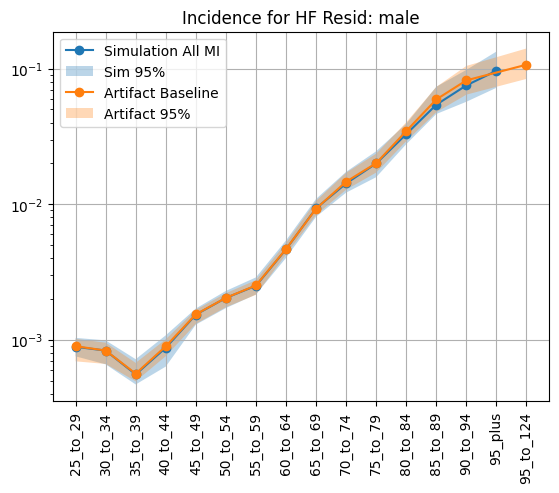

In [82]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [83]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [84]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.005224  0.004814   
1  female       30.0     35.0        2019      2020  0.006428  0.005852   
2  female       35.0     40.0        2019      2020  0.008055  0.007426   
3  female       40.0     45.0        2019      2020  0.010388  0.009147   
4  female       45.0     50.0        2019      2020  0.014368  0.011934   

      97.5% location     measure age_group  
0  0.005703  Alabama  prevalence  25_to_29  
1  0.007333  Alabama  prevalence  30_to_34  
2  0.009693  Alabama  prevalence  35_to_39  
3  0.013053  Alabama  prevalence  40_to_44  
4  0.017636  Alabama  prevalence  45_to_49

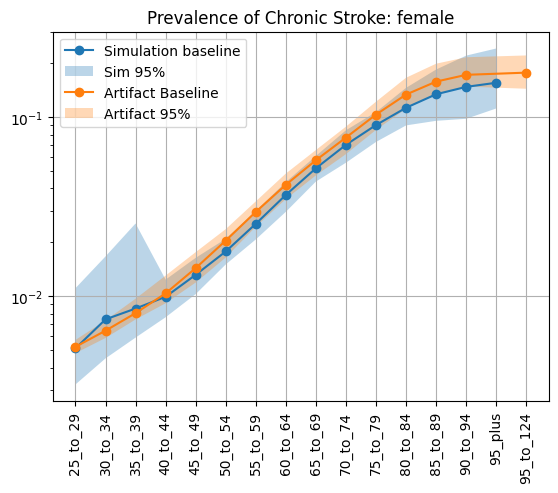

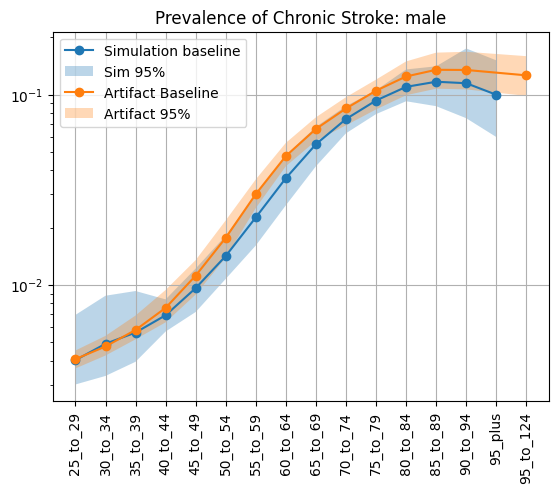

In [85]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [86]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [87]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

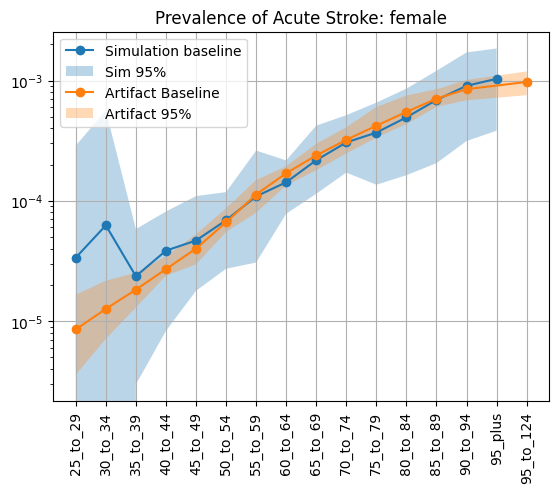

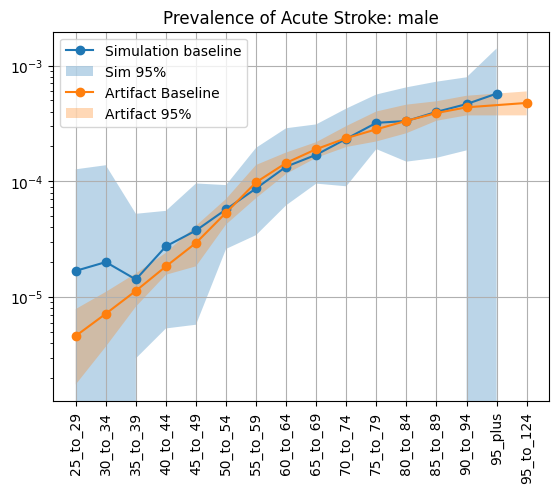

In [88]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [89]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.001324  0.000898   
1  female       30.0     35.0        2019      2020  0.002778  0.002055   
2  female       35.0     40.0        2019      2020  0.004338  0.003549   
3  female       40.0     45.0        2019      2020  0.005999  0.005198   
4  female       45.0     50.0        2019      2020  0.007896  0.007217   

      97.5% location     measure age_group  
0  0.001593  Alabama  prevalence  25_to_29  
1  0.003226  Alabama  prevalence  30_to_34  
2  0.004908  Alabama  prevalence  35_to_39  
3  0.006887  Alabama  prevalence  40_to_44  
4  0.008477  Alabama  prevalence  45_to_49

In [90]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.002909  0.000986  0.007277
1  25_to_29  female  2024  0.003294  0.000757  0.009114
2  25_to_29  female  2025  0.003608  0.000477  0.010417
3  25_to_29  female  2026  0.003697  0.000361  0.010982
4  25_to_29  female  2027  0.003820  0.000296  0.011305

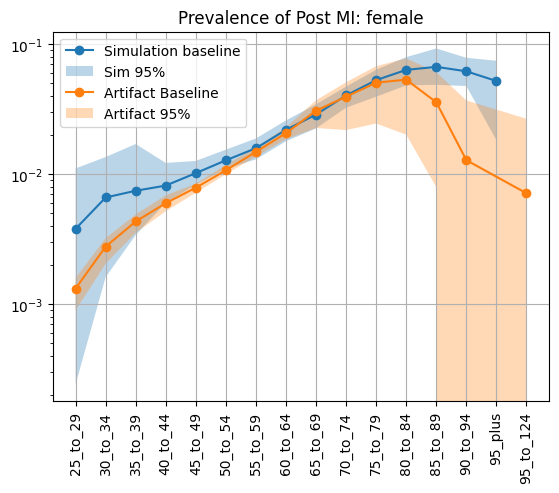

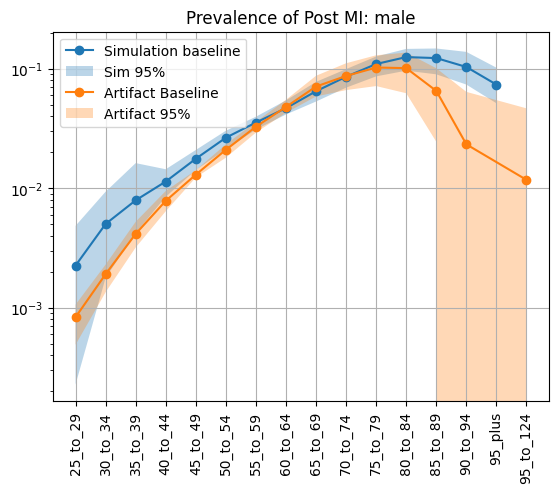

In [93]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [118]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [92]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000028  0.000018   
1  female       30.0     35.0        2019      2020  0.000036  0.000024   
2  female       35.0     40.0        2019      2020  0.000034  0.000028   
3  female       40.0     45.0        2019      2020  0.000040  0.000035   
4  female       45.0     50.0        2019      2020  0.000057  0.000046   

      97.5% location     measure age_group  
0  0.000035  Alabama  prevalence  25_to_29  
1  0.000046  Alabama  prevalence  30_to_34  
2  0.000041  Alabama  prevalence  35_to_39  
3  0.000045  Alabama  prevalence  40_to_44  
4  0.000066  Alabama  prevalence  45_to_49

In [94]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.000106  0.000000  0.000360
1  25_to_29    male  0.000070  0.000000  0.000184
2  30_to_34  female  0.000090  0.000006  0.000517
3  30_to_34    male  0.000111  0.000017  0.000584
4  35_to_39  female  0.000052  0.000018  0.000126

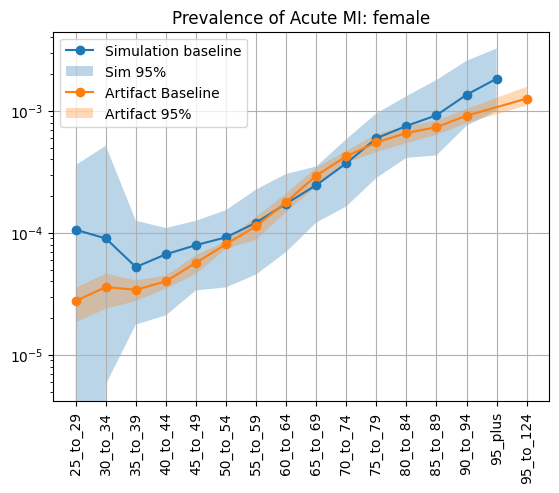

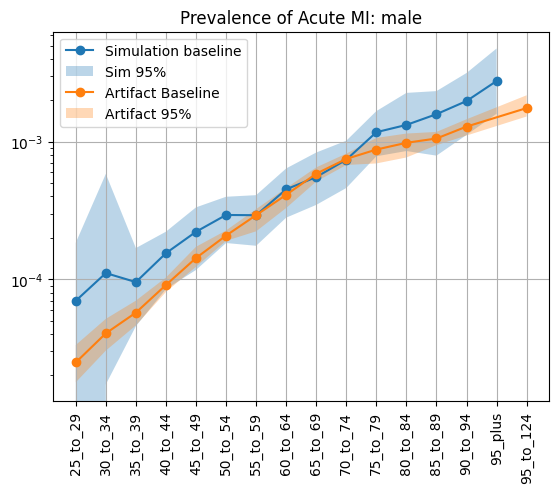

In [95]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [97]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000225  0.000171   
1  female       30.0     35.0        2019      2020  0.000493  0.000363   
2  female       35.0     40.0        2019      2020  0.000726  0.000568   
3  female       40.0     45.0        2019      2020  0.000797  0.000652   
4  female       45.0     50.0        2019      2020  0.001622  0.001454   

      97.5% location     measure age_group  
0  0.000290  Alabama  prevalence  25_to_29  
1  0.000690  Alabama  prevalence  30_to_34  
2  0.000939  Alabama  prevalence  35_to_39  
3  0.000922  Alabama  prevalence  40_to_44  
4  0.001771  Alabama  prevalence  45_to_49

In [98]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.000183  0.000002  0.000333
1  25_to_29    male  0.000457  0.000230  0.000725
2  30_to_34  female  0.000404  0.000195  0.000625
3  30_to_34    male  0.000853  0.000597  0.001380
4  35_to_39  female  0.000542  0.000293  0.000844

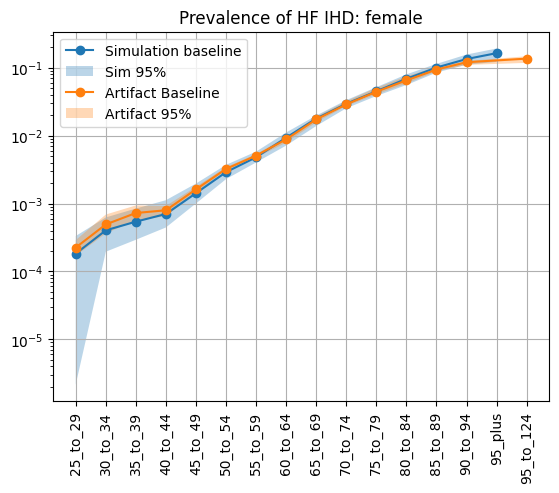

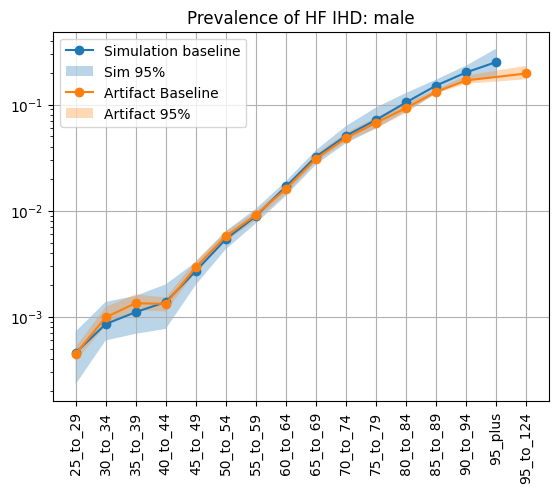

In [99]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [100]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.002356  0.001791   
1  female       30.0     35.0        2019      2020  0.003448  0.002536   
2  female       35.0     40.0        2019      2020  0.003199  0.002500   
3  female       40.0     45.0        2019      2020  0.002921  0.002391   
4  female       45.0     50.0        2019      2020  0.004252  0.003810   

      97.5% location     measure age_group  
0  0.003035  Alabama  prevalence  25_to_29  
1  0.004820  Alabama  prevalence  30_to_34  
2  0.004135  Alabama  prevalence  35_to_39  
3  0.003380  Alabama  prevalence  40_to_44  
4  0.004641  Alabama  prevalence  45_to_49

In [101]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.002353  0.001472  0.003345
1  25_to_29    male  0.003111  0.002533  0.003838
2  30_to_34  female  0.003269  0.002211  0.005070
3  30_to_34    male  0.004325  0.003247  0.005474
4  35_to_39  female  0.003376  0.002570  0.004492

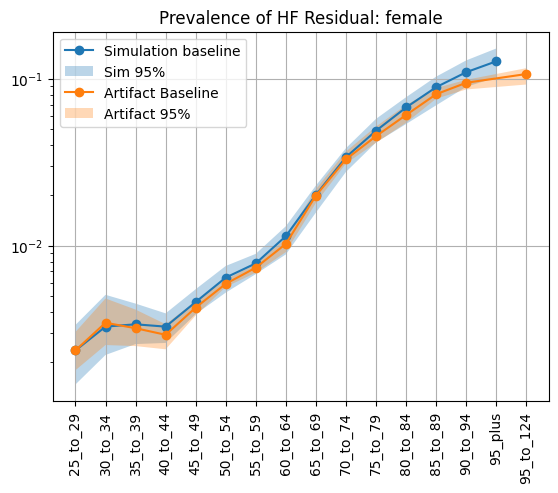

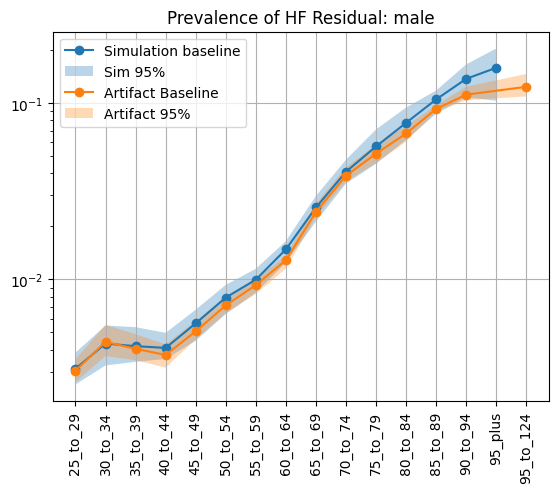

In [102]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [103]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.303283  0.243083   
1  female       30.0     35.0        2019      2020  0.289921  0.217835   
2  female       35.0     40.0        2019      2020  0.308659  0.268634   
3  female       40.0     45.0        2019      2020  0.310392  0.256073   
4  female       45.0     50.0        2019      2020  0.295119  0.237910   

      97.5% location                measure age_group  
0  0.410056  Alabama  excess_mortality_rate  25_to_29  
1  0.390629  Alabama  excess_mortality_rate  30_to_34  
2  0.346739  Alabama  excess_mortality_rate  35_to_39  
3  0.376779  Alabama  excess_mortality_rate  40_to_44  
4  0.342934  Alabama  excess_mortality_rate  45_to_49

In [104]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.303922   0.0  3.125279
1  25_to_29    male  0.596201   0.0  4.402567
2  30_to_34  female  0.211509   0.0  2.608929
3  30_to_34    male  0.509744   0.0  4.130804
4  35_to_39  female  0.341513   0.0  2.247871

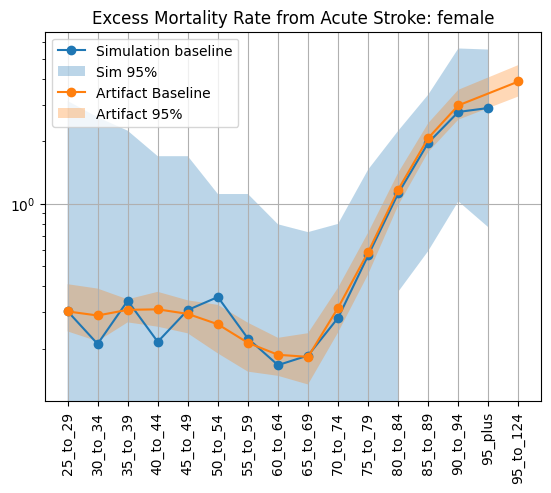

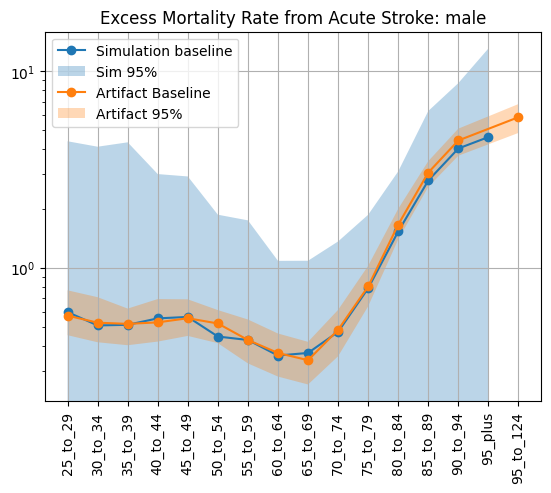

In [105]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [106]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [107]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

age     sex      mean  2.5%  97.5%
0  25_to_29  female  0.000101   0.0    0.0
1  25_to_29    male  0.000000   0.0    0.0
2  30_to_34  female  0.000119   0.0    0.0
3  30_to_34    male  0.000000   0.0    0.0
4  35_to_39  female  0.000050   0.0    0.0

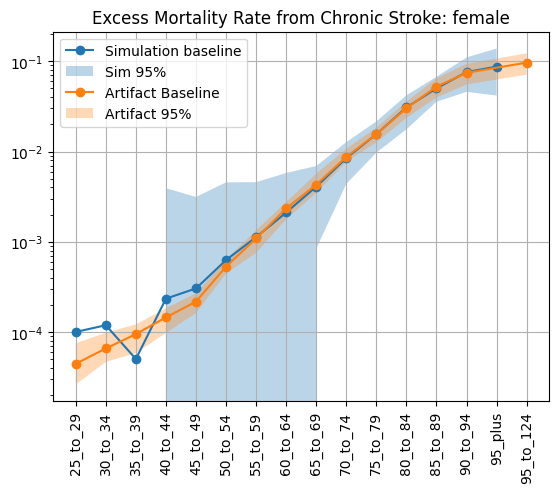

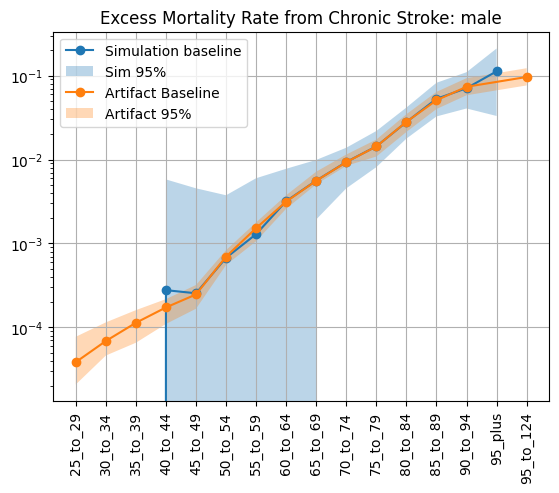

In [108]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [109]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [110]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [111]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  3.380217  0.466497  7.801208
1  25_to_29  female  2024  2.756898  0.000000  4.704625
2  25_to_29  female  2025  3.100329  1.956696  5.859035
3  25_to_29  female  2026  2.566473  0.372704  4.233220
4  25_to_29  female  2027  3.559432  1.546961  7.639269

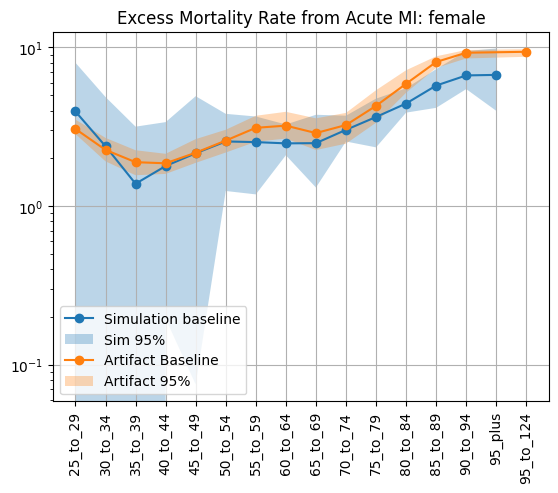

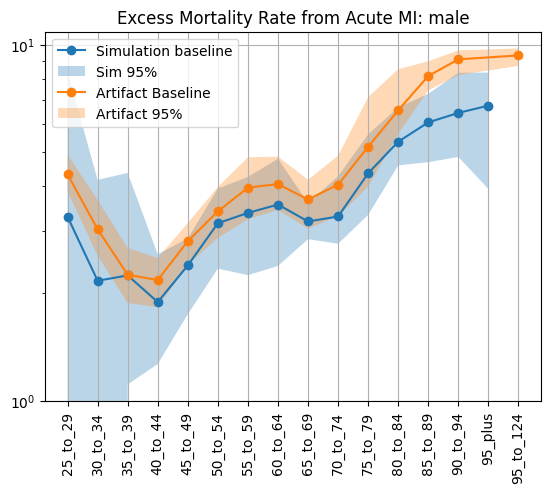

In [113]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [114]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.048359   0.0  0.138315
1  25_to_29    male  0.059833   0.0  0.173412
2  30_to_34  female  0.025095   0.0  0.057293
3  30_to_34    male  0.029083   0.0  0.069595
4  35_to_39  female  0.016216   0.0  0.042914

In [115]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

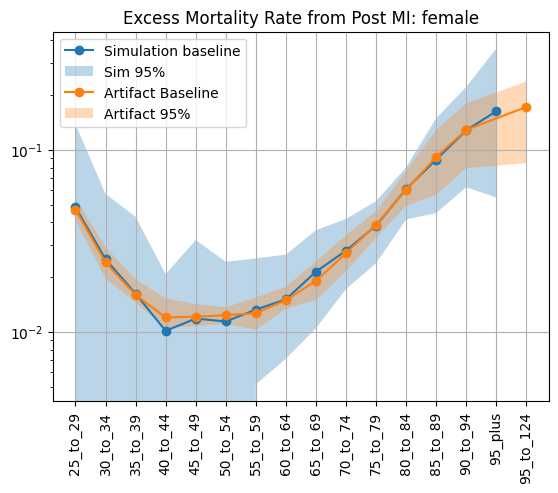

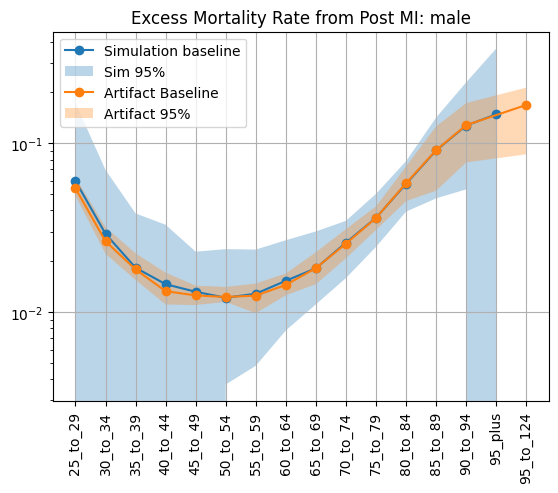

In [116]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [117]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.155052  0.125455   
1  female       30.0     35.0        2019      2020  0.129896  0.106289   
2  female       35.0     40.0        2019      2020  0.163919  0.134336   
3  female       40.0     45.0        2019      2020  0.189839  0.154787   
4  female       45.0     50.0        2019      2020  0.207657  0.185494   

      97.5% location                measure age_group  
0  0.185348  Alabama  excess_mortality_rate  25_to_29  
1  0.158352  Alabama  excess_mortality_rate  30_to_34  
2  0.193534  Alabama  excess_mortality_rate  35_to_39  
3  0.231366  Alabama  excess_mortality_rate  40_to_44  
4  0.232028  Alabama  excess_mortality_rate  45_to_49

In [118]:
HF_emr_allyear = (HF_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

age     sex      mean       50%  2.5%     97.5%
0  25_to_29  female       inf  0.152700   0.0  5.812539
1  25_to_29    male  0.445772  0.182900   0.0  2.105728
2  30_to_34  female  0.374052  0.128125   0.0  2.202558
3  30_to_34    male  0.267050  0.128264   0.0  1.121415
4  35_to_39  female  0.361374  0.166477   0.0  1.513746

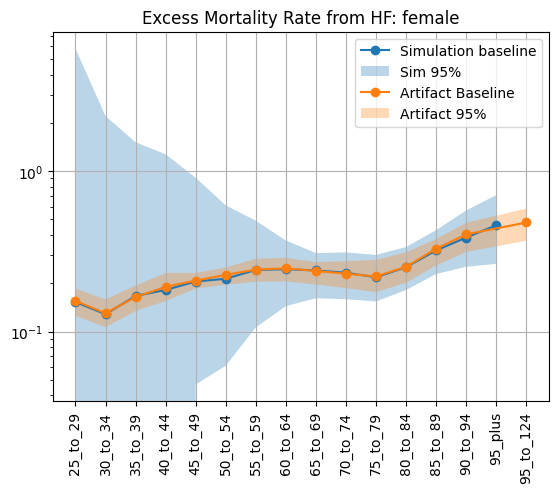

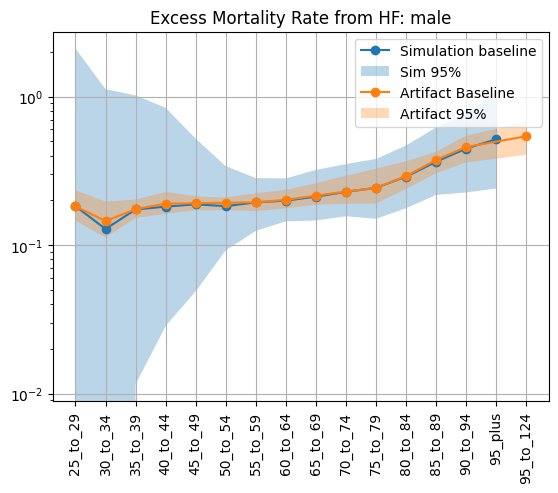

In [119]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

When I changed it to the median it matches exactly

# GBD Comparison

#### All Cause Mortality Rate

In [120]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


In [121]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       294          523           1          3       1   
1            10       294          523           1          3       2   
2            11       294          523           1          3       1   
3            11       294          523           1          3       2   
4            12       294          523           1          3       1   

   year_id acause age_group_name  cause_name  ... location_name location_type  \
0     2019   _all       25 to 29  All causes  ...       Alabama        admin1   
1     2019   _all       25 to 29  All causes  ...       Alabama        admin1   
2     2019   _all       30 to 34  All causes  ...       Alabama        admin1   
3     2019   _all       30 to 34  All causes  ...       Alabama        admin1   
4     2019   _all       35 to 39  All causes  ...       Alabama        admin1   

  measure measure_name metric_name     sex       val     upper     lower  \
0   death       Deaths        Rate    Male  0.002153  0.002516  0.001834   
1   death       Deaths        Rate  Female  0.000950  0.001237  0.000706   
2   death       Deaths        Rate    Male  0.002456  0.002887  0.002079   
3   death       Deaths        Rate  Female  0.001364  0.001755  0.001029   
4   death       Deaths        Rate    Male  0.003056  0.003710  0.002501   

        age  
0  25_to_29  
1  25_to_29  
2  30_to_34  
3  30_to_34  
4  35_to_39  

[5 rows x 21 columns]

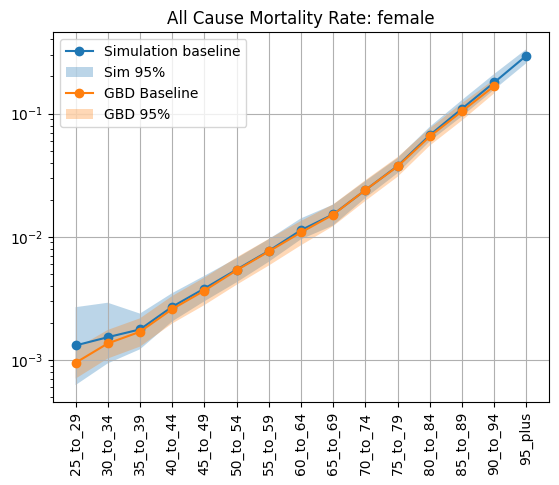

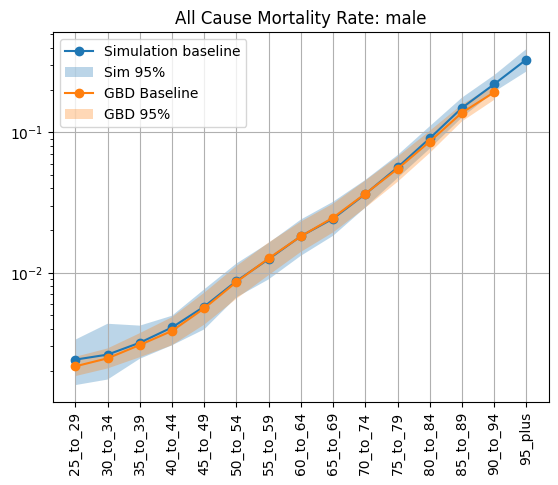

In [122]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [123]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


In [124]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       495          523           6          3       1   
1            10       495          523           6          3       2   
2            11       495          523           6          3       1   
3            11       495          523           6          3       2   
4            12       495          523           6          3       1   

   year_id           acause age_group_name       cause_name  ...  \
0     2019  cvd_stroke_isch       25 to 29  Ischemic stroke  ...   
1     2019  cvd_stroke_isch       25 to 29  Ischemic stroke  ...   
2     2019  cvd_stroke_isch       30 to 34  Ischemic stroke  ...   
3     2019  cvd_stroke_isch       30 to 34  Ischemic stroke  ...   
4     2019  cvd_stroke_isch       35 to 39  Ischemic stroke  ...   

  location_name location_type    measure measure_name metric_name     sex  \
0       Alabama        admin1  incidence    Incidence        Rate    Male   
1       Alabama        admin1  incidence    Incidence        Rate  Female   
2       Alabama        admin1  incidence    Incidence        Rate    Male   
3       Alabama        admin1  incidence    Incidence        Rate  Female   
4       Alabama        admin1  incidence    Incidence        Rate    Male   

        val     upper     lower       age  
0  0.000068  0.000147  0.000025  25_to_29  
1  0.000115  0.000224  0.000050  25_to_29  
2  0.000098  0.000171  0.000052  30_to_34  
3  0.000162  0.000265  0.000091  30_to_34  
4  0.000145  0.000243  0.000077  35_to_39  

[5 rows x 21 columns]

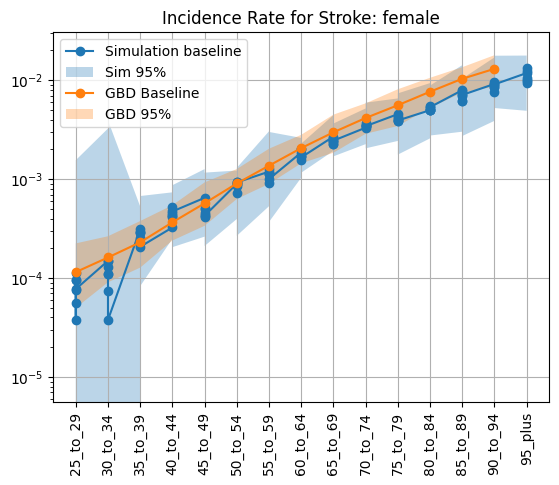

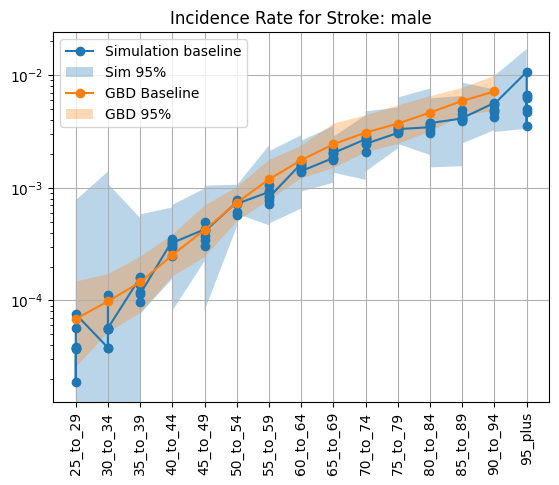

In [125]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [126]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          523           6          3       1   
1            10       493          523           6          3       2   
2            11       493          523           6          3       1   
3            11       493          523           6          3       2   
4            12       493          523           6          3       1   

   year_id   acause age_group_name              cause_name  ... location_name  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...       Alabama   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...       Alabama   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...       Alabama   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...       Alabama   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease  ...       Alabama   

  location_type    measure measure_name metric_name     sex       val  \
0        admin1  incidence    Incidence        Rate    Male  0.000441   
1        admin1  incidence    Incidence        Rate  Female  0.000452   
2        admin1  incidence    Incidence        Rate    Male  0.000621   
3        admin1  incidence    Incidence        Rate  Female  0.000510   
4        admin1  incidence    Incidence        Rate    Male  0.000777   

      upper     lower       age  
0  0.000626  0.000274  25_to_29  
1  0.000616  0.000284  25_to_29  
2  0.000818  0.000448  30_to_34  
3  0.000683  0.000345  30_to_34  
4  0.001081  0.000536  35_to_39  

[5 rows x 21 columns]

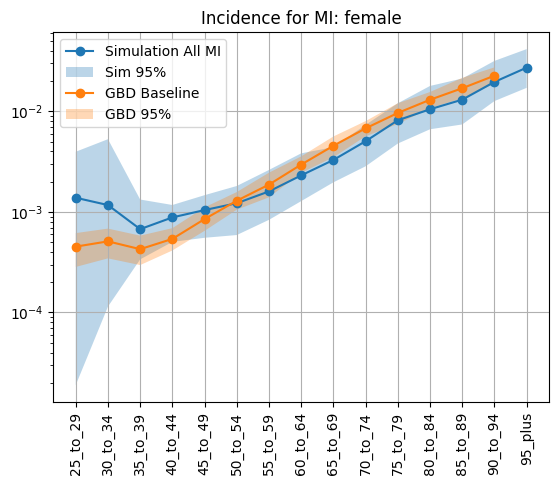

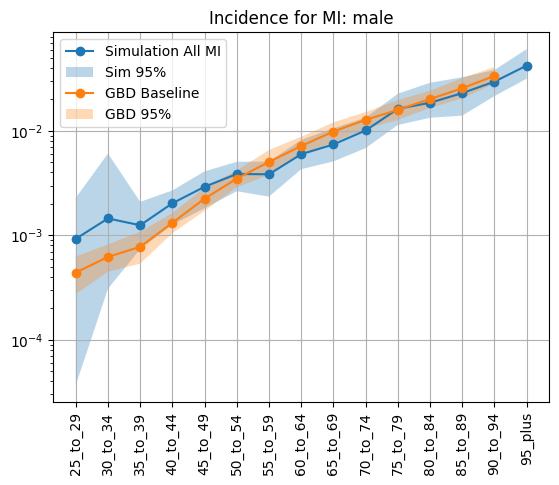

In [127]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [128]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [129]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.001380  0.000000  0.004587
1  25_to_29    male  0.000923  0.000000  0.002459
2  30_to_34  female  0.001167  0.000074  0.006588
3  30_to_34    male  0.001445  0.000215  0.007653
4  35_to_39  female  0.000672  0.000231  0.001539

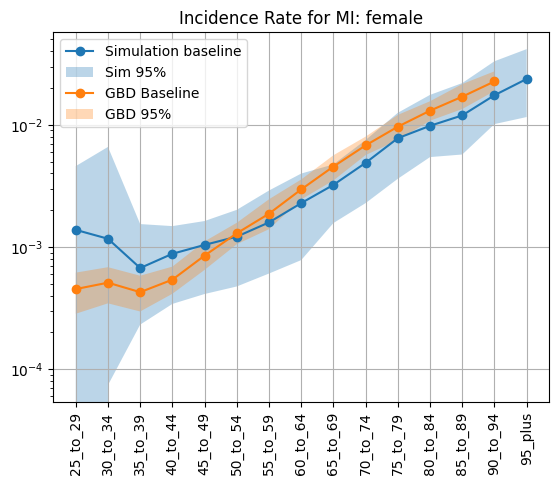

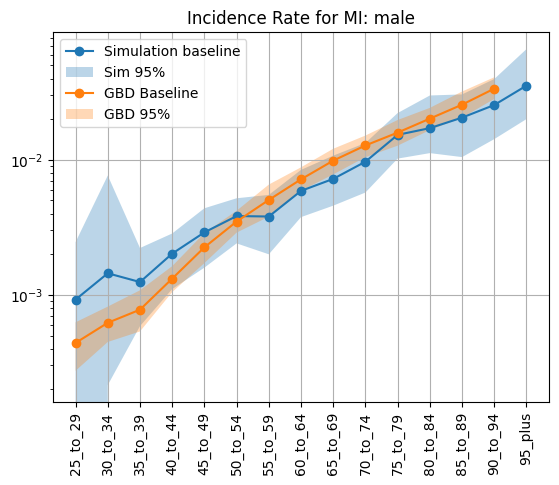

In [130]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [155]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [156]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          523           2          3       1   
1            10       493          523           2          3       2   
2            11       493          523           2          3       1   
3            11       493          523           2          3       2   
4            12       493          523           2          3       1   

   year_id   acause age_group_name              cause_name expected  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease    False   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease    False   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease    False   

  location_name location_type                            measure_name  \
0       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
1       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
2       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
3       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   
4       Alabama        admin1  DALYs (Disability-Adjusted Life Years)   

  metric_name     sex       val     upper     lower       age  
0        Rate    Male  0.002084  0.002684  0.001595  25_to_29  
1        Rate  Female  0.001076  0.001488  0.000753  25_to_29  
2        Rate    Male  0.005151  0.006505  0.003896  30_to_34  
3        Rate  Female  0.002720  0.003687  0.001977  30_to_34  
4        Rate    Male  0.012157  0.015460  0.009483  35_to_39

In [157]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [158]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

age     sex  year  input_draw         yll       yld        daly
0  25_to_29  female  2023          29  121.859670  0.052459  121.912129
1  25_to_29  female  2023         232    0.000000  0.218579    0.218579
2  25_to_29  female  2023         357  602.403744  0.096175  602.499918
3  25_to_29  female  2023         394  495.155492  0.043716  495.199208
4  25_to_29  female  2023         602  679.064381  0.227322  679.291703

In [159]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.022725  0.000005  0.064556
1  25_to_29    male  0.024604  0.000005  0.083176
2  30_to_34  female  0.013766  0.002188  0.042512
3  30_to_34    male  0.020852  0.002176  0.084326
4  35_to_39  female  0.008345  0.000013  0.018033

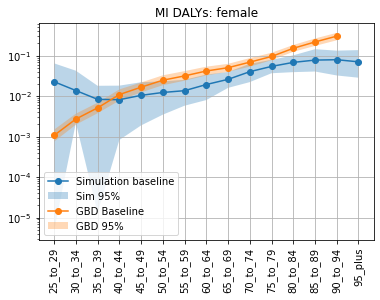

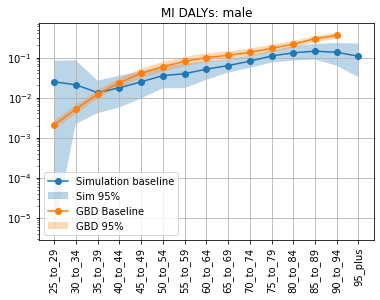

In [160]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Incidence of Heart Failure (need to be overall)

In [132]:
gbd_hf_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 6,
         metric_id = 3,
         source='epi')

ValueError: We tried to look for draws in {'/home/j/ARCHIVES/2019_Archive/epi/panda_cascade/prod/'}. None of the directories exist. Are you sure that specified version is valid? 

In [162]:
gbd_hf_inc_data = gbd_hf_inc.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_inc = pd.concat([gbd_hf_inc, gbd_hf_inc_data], axis=1)
gbd_hf_inc['age_group'] = np.where(gbd_hf_inc['age_group_id']==10,'25_to_29',np.where(gbd_hf_inc['age_group_id']==11,'30_to_34',np.where(gbd_hf_inc['age_group_id']==12,'35_to_39',np.where(gbd_hf_inc['age_group_id']==13,'40_to_44',np.where(gbd_hf_inc['age_group_id']==14,'45_to_49',np.where(gbd_hf_inc['age_group_id']==15,'50_to_54',np.where(gbd_hf_inc['age_group_id']==16,'55_to_59',np.where(gbd_hf_inc['age_group_id']==17,'60_to_64',np.where(gbd_hf_inc['age_group_id']==18,'65_to_69',np.where(gbd_hf_inc['age_group_id']==19,'70_to_74',np.where(gbd_hf_inc['age_group_id']==20,'75_to_79',np.where(gbd_hf_inc['age_group_id']==30,'80_to_84',np.where(gbd_hf_inc['age_group_id']==31,'85_to_89',np.where(gbd_hf_inc['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_inc['sex'] = np.where(gbd_hf_inc['sex_id']==1,'male','female')
gbd_hf_inc

age_group_id    draw_0    draw_1   draw_10  draw_100  draw_101  draw_102  \
0             10  0.000580  0.000645  0.000652  0.000764  0.000696  0.000682   
1             11  0.000560  0.000678  0.000653  0.000726  0.000681  0.000636   
2             12  0.000393  0.000596  0.000531  0.000463  0.000533  0.000376   
3             13  0.000739  0.000970  0.000866  0.000735  0.001012  0.000783   
..           ...       ...       ...       ...       ...       ...       ...   
24            20  0.034810  0.026173  0.025815  0.039883  0.029950  0.030561   
25            30  0.056762  0.045549  0.040194  0.057717  0.047708  0.048105   
26            31  0.087391  0.073970  0.061637  0.080458  0.073133  0.073803   
27            32  0.112624  0.097711  0.081192  0.098915  0.094516  0.096933   

    draw_103  draw_104  draw_105  ...  year_id  metric_id  model_version_id  \
0   0.000654  0.000598  0.000591  ...     2019          3            474434   
1   0.000672  0.000580  0.000584  ...     2019          3            474434   
2   0.000585  0.000417  0.000436  ...     2019          3            474434   
3   0.000880  0.000950  0.000795  ...     2019          3            474434   
..       ...       ...       ...  ...      ...        ...               ...   
24  0.028690  0.036332  0.031442  ...     2019          3            474434   
25  0.050991  0.057631  0.049395  ...     2019          3            474434   
26  0.082938  0.087029  0.074230  ...     2019          3            474434   
27  0.108672  0.110924  0.094541  ...     2019          3            474434   

    modelable_entity_id  index      mean      2.5%     97.5%  age_group  \
0                  2412      0  0.000654  0.000474  0.000861   25_to_29   
1                  2412      1  0.000643  0.000479  0.000823   30_to_34   
2                  2412      2  0.000479  0.000302  0.000696   35_to_39   
3                  2412      3  0.000859  0.000639  0.001106   40_to_44   
..                  ...    ...       ...       ...       ...        ...   
24                 2412     24  0.031995  0.024954  0.039942   75_to_79   
25                 2412     25  0.051916  0.042305  0.061660   80_to_84   
26                 2412     26  0.080312  0.062431  0.100092   85_to_89   
27                 2412     27  0.104392  0.079426  0.134527   90_to_94   

       sex  
0   female  
1   female  
2   female  
3   female  
..     ...  
24    male  
25    male  
26    male  
27    male  

[28 rows x 1014 columns]

In [163]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000729  0.000449  0.000973
         male    0.001079  0.000826  0.001164
30_to_34 female  0.000740  0.000520  0.000938
         male    0.000963  0.000770  0.001182
35_to_39 female  0.000542  0.000443  0.000643

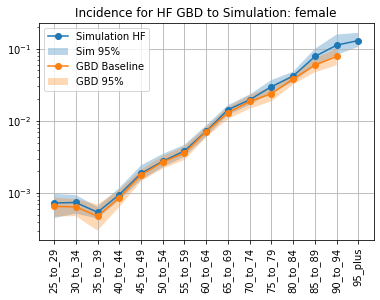

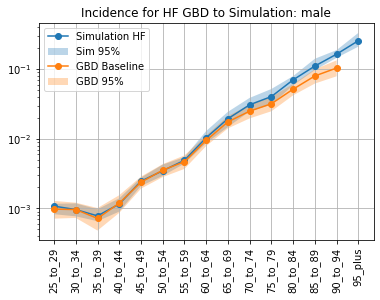

In [164]:
for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = gbd_hf_inc.loc[(gbd_hf_inc.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF GBD to Simulation: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation HF', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Prevalence of Heart Failure

In [131]:
gbd_hf_prev = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 5,
         metric_id = 3,
         source='epi')

ValueError: We tried to look for draws in {'/home/j/ARCHIVES/2019_Archive/epi/panda_cascade/prod/'}. None of the directories exist. Are you sure that specified version is valid? 

In [166]:
gbd_hf_prev_data = gbd_hf_prev.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_prev = pd.concat([gbd_hf_prev, gbd_hf_prev_data], axis=1)
gbd_hf_prev['age_group'] = np.where(gbd_hf_prev['age_group_id']==10,'25_to_29',np.where(gbd_hf_prev['age_group_id']==11,'30_to_34',np.where(gbd_hf_prev['age_group_id']==12,'35_to_39',np.where(gbd_hf_prev['age_group_id']==13,'40_to_44',np.where(gbd_hf_prev['age_group_id']==14,'45_to_49',np.where(gbd_hf_prev['age_group_id']==15,'50_to_54',np.where(gbd_hf_prev['age_group_id']==16,'55_to_59',np.where(gbd_hf_prev['age_group_id']==17,'60_to_64',np.where(gbd_hf_prev['age_group_id']==18,'65_to_69',np.where(gbd_hf_prev['age_group_id']==19,'70_to_74',np.where(gbd_hf_prev['age_group_id']==20,'75_to_79',np.where(gbd_hf_prev['age_group_id']==30,'80_to_84',np.where(gbd_hf_prev['age_group_id']==31,'85_to_89',np.where(gbd_hf_prev['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_prev['sex'] = np.where(gbd_hf_prev['sex_id']==1,'male','female')
gbd_hf_prev

age_group_id    draw_0    draw_1   draw_10  draw_100  draw_101  draw_102  \
0             10  0.002602  0.002432  0.002289  0.002948  0.002625  0.002922   
1             11  0.003730  0.003362  0.003287  0.004099  0.003751  0.004369   
2             12  0.003570  0.003483  0.003662  0.004097  0.003479  0.003984   
3             13  0.003256  0.003702  0.004112  0.003935  0.003278  0.003298   
..           ...       ...       ...       ...       ...       ...       ...   
24            20  0.112510  0.109840  0.115690  0.118510  0.107500  0.112420   
25            30  0.148220  0.149990  0.159450  0.149970  0.148380  0.149230   
26            31  0.217350  0.221070  0.213370  0.208870  0.214470  0.202890   
27            32  0.281140  0.283330  0.254370  0.270000  0.273960  0.246420   

    draw_103  draw_104  draw_105  ...  year_id  metric_id  model_version_id  \
0   0.002295  0.002586  0.002454  ...     2019          3            474434   
1   0.003254  0.003637  0.003456  ...     2019          3            474434   
2   0.003749  0.003560  0.003383  ...     2019          3            474434   
3   0.004402  0.003590  0.003268  ...     2019          3            474434   
..       ...       ...       ...  ...      ...        ...               ...   
24  0.115820  0.121190  0.118430  ...     2019          3            474434   
25  0.157900  0.163240  0.158390  ...     2019          3            474434   
26  0.237280  0.235780  0.225920  ...     2019          3            474434   
27  0.307470  0.301880  0.289700  ...     2019          3            474434   

    modelable_entity_id  index      mean      2.5%     97.5%  age_group  \
0                  2412      0  0.002565  0.001943  0.003309   25_to_29   
1                  2412      1  0.003761  0.002759  0.004986   30_to_34   
2                  2412      2  0.003672  0.002782  0.004679   35_to_39   
3                  2412      3  0.003482  0.002716  0.004423   40_to_44   
..                  ...    ...       ...       ...       ...        ...   
24                 2412     24  0.117334  0.099809  0.137511   75_to_79   
25                 2412     25  0.156597  0.134990  0.182642   80_to_84   
26                 2412     26  0.221997  0.197069  0.250608   85_to_89   
27                 2412     27  0.279154  0.241288  0.323885   90_to_94   

       sex  
0   female  
1   female  
2   female  
3   female  
..     ...  
24    male  
25    male  
26    male  
27    male  

[28 rows x 1014 columns]

In [167]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.002740  0.001842  0.003813
1  25_to_29    male  0.003662  0.002739  0.004913
2  30_to_34  female  0.003918  0.002603  0.005647
3  30_to_34    male  0.005062  0.003769  0.006917
4  35_to_39  female  0.004085  0.002740  0.005482

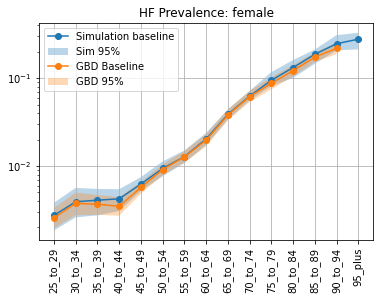

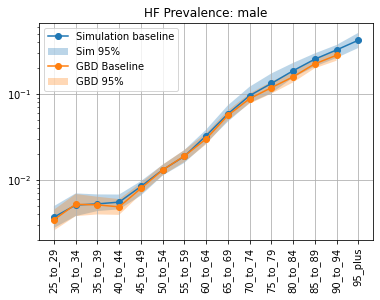

In [168]:
for sex in prev_HF_summ.sex.unique():
    plt.figure() 
    subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_hf_prev.loc[(gbd_hf_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'HF Prevalence: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 